In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import time
import pickle
from datetime import datetime, date, timedelta
from numpy.lib.stride_tricks import sliding_window_view
import cache_replacement_policies
import glob

1. PREPROCESAMIENTO

In [2]:
def compare_last_csvs(csv_list,pickle_file_path):
    with open(pickle_file_path, 'rb') as archivo_pickle:
        old_csv_list = pickle.load(archivo_pickle)

    csv_list = list(set(new_csv_list) - set(old_csv_list))
    csv_flag =  bool(csv_list)

    return csv_flag, csv_list

def read_new_csvs(csv_list,url_csv_list):
    # VARIABLES FIJAS
    columnas = ["TiempoUnix", "JobID", "Archivo", "Tamano", "CentroEjecucion", "CentroApertura", "EficienciaCPU", "CPUtime", "Walltime"]
    data_dict = {} # Dict que guarda los tres data de los 3 centros
    url_data_dict = {}


    # Lectura de datos
    for site in ['PIC', 'CIEMAT', 'IFCA']:
        csv_site_list = list(filter(lambda x: x.split("_")[-2] == site, csv_list)) # Csvs del site concreto (PIC por ejemplo)
        url_csv_site_list = list(filter(lambda x: x.split("_")[-2] == site, url_csv_list)) # Csvs del site concreto (PIC por ejemplo) 
        
        if csv_site_list: # Si hay csvs del sitio
            data_dict[site] = pd.concat(
                (pd.read_csv(os.path.join(directory_path, "out_processed", file), names=columnas, index_col=False) for file in csv_site_list), ignore_index=True
            )

            # Añadir conteo de urls
            url_data_dict[site] = pd.concat(
                (pd.read_csv(os.path.join(directory_path, "out_swan", file), usecols=["GlobalJobId"])for file in url_csv_list), ignore_index=True
            )

            # Reemplazar NAs de Tamaño por 2.9 GB
            data_dict[site].loc[data_dict[site]["Tamano"].isna(), "Tamano"] = 2.9 * 1024 * 1024 * 1024 # Mirar si se puede hacer una media

            # Pasar a GB
            data_dict[site]['Tamano'] = data_dict[site]['Tamano'].astype(int) / 1024 / 1024 / 1024
            
            data_dict[site]['Flag'] = "Nuevo"
    
    return data_dict

def join_datas(data_temp, data_dict, last_data_pickle_file_path):   #NUEVA MANTENER ESTA  
    data_temp["Flag"] = "Viejo"
    
    data = pd.concat([data_dict[site] for site in ['PIC', 'CIEMAT', 'IFCA'] if site in data_dict] + [data_temp])
    
    print(f"Numero de archivo duplicados {data.duplicated().sum()}")
    
    data.drop_duplicates(inplace=True)
    
    print(f"Numero de archivo duplicados según el nombre y el tiempounix: {data.duplicated(subset=['Archivo', 'TiempoUnix'], keep=False).sum()} (debería haber 0)")
    
    data.to_pickle(last_data_pickle_file_path)
    
    return data

def modify_data(data):
    data.sort_values("TiempoUnix", inplace=True)
    data["Dia"] = pd.to_datetime(data["TiempoUnix"], unit='s').dt.date
    
    # En arbol raw tendra la forma de /store/data/.../RAW para en el bucle de cache no tener que extraer un atributo mas (provoca aumento de latencia)
    data['Arbol'] = data['Archivo'].apply(lambda row:'/'.join(row.split('/')[:3]))
    data['Tipo'] = data['Archivo'].apply(lambda row:row.split('/')[5])
    condition = (data['Tipo'] == 'RAW') & (data['Arbol'] == '/store/data')
    data.loc[condition, 'Arbol'] = data.loc[condition, 'Arbol'] + '/.../RAW'

    #Para cache base (solo atributos necesarios)
    data_cache = data[['Arbol','Archivo','Tamano','TiempoUnix']]

    grupos_duplicados = data.groupby(['Archivo', 'TiempoUnix']).filter(lambda group: len(group) > 1).groupby(['Archivo', 'TiempoUnix']).head(1)
    data_no_duplicados = data.groupby(['Archivo', 'TiempoUnix']).filter(lambda group: len(group) == 1)

    data = pd.concat([data_no_duplicados, grupos_duplicados])
    data.sort_values("TiempoUnix", inplace=True)
    return data, data_cache

In [4]:
directory_path = "/data/cms/scratch2/xcache_studies/crab/" # Directorio de csvs
database_path = '/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/' #Directorio dnd se guarda lista de csvs

print("Getting the csvs on the directory...")
new_csv_list = [i for i in os.listdir(os.path.join(directory_path, "out_processed")) if i.endswith('.csv')]
url_csv_list = [i for i in os.listdir(os.path.join(directory_path, "out_swan")) if i.endswith('.csv')]

csv_list_pickle_file_path = os.path.join(database_path, 'LAST_CSV_LISTS.pkl')
last_data_pickle_file_path = os.path.join(database_path, 'LAST_data.pkl')

print("Getting already readed csvs...")
data = pd.read_pickle(last_data_pickle_file_path)

# Compara lista actual con última ejecucución, devuelve true si hay adiciones
print("Comparing old with new csvs...")
csv_flag, csv_list = compare_last_csvs(new_csv_list,csv_list_pickle_file_path)

print(f'Changes in csv directory? {csv_flag}')
#Si quiero que me lea todos los nuevos
#respuesta = input("Leer todos los de la carpeta de nuevo?")
respuesta = "no"
if respuesta in "sS":
    csv_list = new_csv_list
    csv_flag = True

if csv_flag:        
    print(f'New csvs: {csv_list}')
    
    #Leer csvs nuevos
    data_dict = read_new_csvs(csv_list, url_csv_list)
    
    #Juntar nuevos con los que ya están guardados en pkl, guardar nueva data
    data = join_datas(data, data_dict, last_data_pickle_file_path)
    
    with open(csv_list_pickle_file_path, 'wb') as archivo_pickle:
        pickle.dump(new_csv_list, archivo_pickle)
        
#Añadir nuevas columnas, arbol y todo eso.
print("Modifying data...")
data, data_cache = modify_data(data) #data_cache no lo utilizo, añadir luego

Getting the csvs on the directory...
Getting already readed csvs...
Comparing old with new csvs...
Changes in csv directory? True
New csvs: ['20240216_T2_ES_IFCA_processed.csv', '20240216_T1_ES_PIC_processed.csv', '20240214_T1_ES_PIC_processed.csv', '20240214_T2_ES_CIEMAT_processed.csv', '20240215_T2_ES_CIEMAT_processed.csv', '20240215_T1_ES_PIC_processed.csv', '20240216_T2_ES_CIEMAT_processed.csv', '20240215_T2_ES_IFCA_processed.csv', '20240214_T2_ES_IFCA_processed.csv', '20240217_T1_ES_PIC_processed.csv']
Numero de archivo duplicados 659
Numero de archivo duplicados según el nombre y el tiempounix: 1848609 (debería haber 0)
Modifying df...


In [3]:
def get_per_files(directory_path):
    archivos_con_rutas = [os.path.join(directory_path, archivo) for archivo in os.listdir(directory_path)]   
    return archivos_con_rutas

    

def read_per(archivo):
    archivo = '/data/cms/scratch/xcache_studies/crab/cinfo_results/20231006_cinfo.results'
    columnas=['Dia', 'Mes', 'Num', 'Hora', 'Año', 'fname', 'size', 'N_accesses', 'Porcentaje_bajado']
    
    perdata = pd.read_csv(archivo,sep=' ',names=columnas, index_col=False)
    perdata['Porcentaje_bajado'] = perdata['Porcentaje_bajado'].str.rstrip('%').astype(float)
    perdata['Fecha'] = pd.to_datetime(perdata['Año'].astype(str) + perdata['Mes'] + perdata['Num'].astype(str), format='%Y%b%d')
    perdata.drop(['Dia', 'Mes', 'Num', 'Año'], axis=1, inplace=True)
    #perdata['ruta'] = ["/".join(i.split("/")[:-1]) for i in perdata["fname"]] #quitar luego
    perdata["arbol"] = perdata['fname'].apply(lambda x: "/".join(x.split('/')[:3]))
    perdata['type'] = perdata['fname'].apply(lambda x: x.split('/')[:6][-1])

    perdata.loc[perdata["arbol"] == '/store/cmst3', 'type'] = perdata.loc[perdata["arbol"] == '/store/cmst3', 'fname'].apply(lambda x: x.split('/')[:7][-1])
    perdata.loc[perdata["arbol"] == '/store/test', 'type'] = perdata.loc[perdata["arbol"] == '/store/test', 'fname'].apply(lambda x: x.split('/')[:10][-1])



In [5]:
per_directory_path = "/data/cms/scratch2/xcache_studies/crab/xcache_files"
per_files_list = get_per_files(per_directory_path)
per_file = max(per_files_list) #Coger úlit

In [6]:
columnas=['Dia', 'Mes', 'Num', 'Hora', 'Año', 'fname', 'size', 'N_accesses', 'Porcentaje_bajado']
perdata = pd.read_csv(per_file,sep=' ',names=columnas, index_col=False)
perdata['Porcentaje_bajado'] = perdata['Porcentaje_bajado'].str.rstrip('%').astype(float)
perdata['Fecha'] = pd.to_datetime(perdata['Año'].astype(str) + perdata['Mes'] + perdata['Num'].astype(str), format='%Y%b%d')
perdata.drop(['Dia', 'Mes', 'Num', 'Año'], axis=1, inplace=True)
#perdata['ruta'] = ["/".join(i.split("/")[:-1]) for i in perdata["fname"]] #quitar luego
perdata["arbol"] = perdata['fname'].apply(lambda x: "/".join(x.split('/')[:3]))
perdata['type'] = perdata['fname'].apply(lambda x: x.split('/')[:6][-1])

perdata.loc[perdata["arbol"] == '/store/cmst3', 'type'] = perdata.loc[perdata["arbol"] == '/store/cmst3', 'fname'].apply(lambda x: x.split('/')[:7][-1])
perdata.loc[perdata["arbol"] == '/store/test', 'type'] = perdata.loc[perdata["arbol"] == '/store/test', 'fname'].apply(lambda x: x.split('/')[:10][-1])

#perdata.to_pickle('percentage.pkl')
perdata.head(3)

,Hora,fname,size,N_accesses,Porcentaje_bajado,Fecha,arbol,type
0,11:35:49,/store/data/Run2018C/SingleMuon/MINIAOD/UL2018...,3661478kB,1,4.922,2023-09-06,/store/data,MINIAOD
1,11:35:49,/store/data/Run2018C/SingleMuon/MINIAOD/UL2018...,3170050kB,1,4.538,2023-09-06,/store/data,MINIAOD
2,11:35:48,/store/data/Run2018C/SingleMuon/MINIAOD/UL2018...,2097590kB,1,8.323,2023-09-06,/store/data,MINIAOD


In [7]:
data2 = data[data["CentroApertura"] != data["CentroEjecucion"]]

In [8]:
data2.head(3)

,TiempoUnix,JobID,Archivo,Tamano,CentroEjecucion,CentroApertura,EficienciaCPU,CPUtime,Walltime,Flag,Dia,Arbol,Tipo
174385,1685551352,crab3@vocms0198.cern.ch#85354605.0#1685543961,/store/mc/RunIISummer20UL16MiniAODv2/DYJetsToT...,2.144550,T2_ES_IFCA,T2_US_Purdue,14.72761,5242.262,35594.792,Viejo,2023-05-31,/store/mc,MINIAODSIM
174870,1685557838,crab3@vocms0197.cern.ch#91315670.0#1685523376,/store/data/Run2018D/ParkingBPH5/MINIAOD/UL201...,3.274391,T2_ES_IFCA,T1_IT_CNAF,84.83819,22063.323,26006.358,Viejo,2023-05-31,/store/data,MINIAOD
174488,1685557839,crab3@vocms0197.cern.ch#91315669.0#1685523376,/store/data/Run2018D/ParkingBPH5/MINIAOD/UL201...,3.547233,T2_ES_IFCA,T1_IT_CNAF,85.25438,28729.146,33698.146,Viejo,2023-05-31,/store/data,MINIAOD


2. CACHE

In [9]:
def hit_vs_miss_plot_VIEJO(ADDITIONSdata_byday, axis, tres_meses=False):
    misses_list, hits_list = [], []
    miss_bar_list, hit_bar_list = [], []
    miss_n_xday_list, hit_n_xday_list = [], []

    group_sum, hit_sum, miss_sum = 0, 0, 0

    for name, group in ADDITIONSdata_byday:
        misses = group[group['Miss'] == True]
        hits = group[group['Miss'] == False]

        miss_n_xday_list.append(len(misses))
        hit_n_xday_list.append(len(hits))

        misses_list.append(len(misses) * 100 / len(group))
        hits_list.append(len(hits) * 100 / len(group))

    for i, (cumhit, cummiss) in enumerate(zip(np.cumsum(hit_n_xday_list), np.cumsum(miss_n_xday_list))):
        miss_bar_list.append(cummiss * 100 / (cumhit + cummiss))
        hit_bar_list.append(cumhit * 100 / (cumhit + cummiss))

    if tres_meses:
        mes = list(ADDITIONSdata_byday.groups.keys())[-1].month
        fecha = list(ADDITIONSdata_byday.groups.keys())[-1] - timedelta(days=3*30)
        x = [data for data in list(ADDITIONSdata_byday.groups.keys()) if data >= fecha]
    else:
        x = ADDITIONSdata['Dia'].unique()

    n = len(x)

    axis.plot(x, miss_bar_list[-n:], color='darkorange', linewidth=2, label='Linea Misses')
    axis.plot(x, hit_bar_list[-n:], color='steelblue', linewidth=2, label='Linea Hits')
    axis.bar(x, misses_list[-n:], color='darkorange', alpha=0.5, label="Misses")
    axis.bar(x, hits_list[-n:], bottom=misses_list[-n:], color='dodgerblue', alpha=0.5, label="Hits")
    
    extra = ""
    if tres_meses:
        extra = " (3 last months)"

    axis.set_title(f"Hits vs Misses{extra}")
    axis.tick_params(axis='x',labelrotation=45)
    axis.set_ylabel("Files [%]")
    axis.legend(loc='best')
    
    
    return miss_n_xday_list, hit_n_xday_list

def hit_vs_miss_plot(ADDITIONSdata_byday, axis, all_dates, cuatro_meses=False):
    n_hits_miss = ADDITIONSdata_byday['Miss'].size().reindex(all_dates, fill_value=0) #conteo de cuantos por dia

    n_miss = ADDITIONSdata_byday['Miss'].sum().reindex(all_dates, fill_value=0) #Cuantos true
    n_hits = n_hits_miss - n_miss

    #n_miss, n_hits = n_miss.reindex(all_dates, fill_value=0), n_hits.reindex(all_dates, fill_value=0) #añadir 0s en los dias que no hay 

    distribucion_miss,distribucion_hits = (n_miss*100) / n_hits_miss, (n_hits*100) / n_hits_miss
    porcentaje_cumulativo_hits = (n_hits.cumsum() * 100) / n_hits_miss.cumsum()

    axis.bar(all_dates, distribucion_miss, color='darkorange', alpha=0.5, label="Misses")
    axis.bar(all_dates, distribucion_hits, bottom=distribucion_miss, color='dodgerblue', alpha=0.5, label="Hits")
    axis.plot(all_dates, porcentaje_cumulativo_hits, color='steelblue', linewidth=2, label=f'Cumulativo Hits, %Final: {porcentaje_cumulativo_hits[-1]:.2f}')
    axis.set_xlim(all_dates[0]-timedelta(days=1), all_dates[-1])

    extra = ""
    if cuatro_meses:
        first_month, last_month = all_dates[0].strftime('%B'), all_dates[-1].strftime('%B')
        extra = f'From {first_month} {all_dates[0].year} to {last_month} {all_dates[-1].year} '

    axis.set_title(f"Hits vs Misses {extra}")
    axis.tick_params(axis='x',labelrotation=45)
    axis.set_ylabel("Files [%]")
    axis.legend(loc='lower right')

    return porcentaje_cumulativo_hits[-1]

def plot_number_of_files_xday_VIEJO(DELETIONSdata_byday, ADDITIONSdata_byday, axis):
    axis.plot(DELETIONSdata_byday.groups.keys(), DELETIONSdata_byday.size(), label='deletions', color='orchid')
    axis.plot(ADDITIONSdata_byday.groups.keys(), ADDITIONSdata_byday.size(), label='creations', color='steelblue')

    axis.tick_params(axis='x',labelrotation=45)
    axis.grid(True)
    axis.legend()
    
    axis.set_title("Number of deletions vs additions per day")
    axis.set_ylabel("Number of files")

    axis.fill_between(DELETIONSdata_byday.groups.keys(), DELETIONSdata_byday.size(), color='orchid', alpha=0.2)
    axis.fill_between(ADDITIONSdata_byday.groups.keys(), ADDITIONSdata_byday.size(), color='steelblue', alpha=0.2)

def plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday, dates, axis):
    axis.plot(dates, DELETIONSdata_byday.size().reindex(dates, fill_value=0), label='deletions', color='orchid')
    axis.plot(dates, ADDITIONSdata_byday.size().reindex(dates, fill_value=0), label='creations', color='steelblue')

    axis.tick_params(axis='x',labelrotation=45)
    axis.grid(True)
    axis.legend()
    
    axis.set_title("Number of deletions vs additions per day")
    axis.set_ylabel("Number of files")

    axis.fill_between(dates, DELETIONSdata_byday.size().reindex(dates, fill_value=0), color='orchid', alpha=0.2)
    axis.fill_between(dates, ADDITIONSdata_byday.size().reindex(dates, fill_value=0), color='steelblue', alpha=0.2)
    
def plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis):
    timestamp = [pd.Timestamp(i, unit='s') for i in ADDITIONSdata["TiempoUnix"]]

    axis.plot(timestamp, ADDITIONSdata["CacheSize"], linewidth=0.00001)
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    axis.xaxis.set_minor_locator(mdates.DayLocator())
    axis.grid(True)

    axis.axhline(y=SIZE, color='r', linestyle='--')
    axis.axhline(y=max_cache, color='r', linestyle='--')
    axis.axhline(y=cache_restart, color='r', linestyle='--')
    
    axis.set_title("Cache Size Development")
    axis.tick_params(axis='x',labelrotation=90)
    def terabytes_formatter(x, pos):
        return f'{x / (1024):.2f} TB'
    axis.yaxis.set_major_formatter(terabytes_formatter)

    axis.fill_between(timestamp, ADDITIONSdata["CacheSize"], color='y', alpha=0.2)
    axis.fill_between(timestamp, ADDITIONSdata["CacheSize"], SIZE, color='g', alpha=0.2)

def plot_size_times_days_files(STATICDIA_byday, ADDITIONSdata_byday, axis):
    dias = list(ADDITIONSdata_byday.groups.keys())
    nueva_metrica = {dia: 0 for dia in dias}

    for dia, grupo in STATICDIA_byday:
        columna_multiplicacion = (grupo["Size"] * grupo["Diferencia_Dias"]) * (60 * 60 * 24) / (1024)  # de gigas a teras #de dia a segundos
        nueva_metrica[dia] = columna_multiplicacion.sum()

    axis.plot(dias, nueva_metrica.values(), marker='.', markersize=5)
    axis.set_xticks(dias[::15])
    axis.set_xticklabels(dias[::15], rotation=90)
    axis.set_ylabel("Number of size times days files (TB*s)")
    axis.set_title("Size times days files accumulated in cache")
    axis.grid(True)
    
    return nueva_metrica.values()

def num_of_static_files(ADDITIONSdata_byday, STATICDIA, axis):
    dias = list(ADDITIONSdata_byday.groups.keys())
    grafico = [len(STATICDIA[STATICDIA["Dia"] == dia]) for dia in dias]

    axis.bar(dias, grafico)
    axis.set_ylabel('Num of Files')
    axis.set_title('Num of Static Files in Cache per Day')
    axis.grid(True)
    
    axis.tick_params(axis='x',labelrotation=90)

#NO PUESTA
def sum_of_static_files(ADDITIONSdata_byday, STATICDIA, axis):
    dias = list(ADDITIONSdata_byday.groups.keys())
    grafico = [sum(STATICDIA[STATICDIA["Dia"] == dia]["Size"]) for dia in dias]

    axis.bar(dias, grafico)
    axis.set_ylabel('Size of Files')
    axis.set_title('Sum of Sizes of Static Files in Cache per Day')
    axis.grid(True)
    
    axis.tick_params(axis='x',labelrotation=90)
    
def plot_size_times_days_files_cumulativo(STATICDIA_byday, ADDITIONSdata_byday, axis):
    dias = list(ADDITIONSdata_byday.groups.keys())
    nueva_metrica = {dia: 0 for dia in dias}

    for dia, grupo in STATICDIA_byday:
        columna_multiplicacion = (grupo["Size"] * grupo["Diferencia_Dias"]) * (60 * 60 * 24) / (1024)  # de gigas a teras #de dia a segundos
        nueva_metrica[dia] = columna_multiplicacion.sum()

    axis.plot(dias, np.cumsum(list(nueva_metrica.values())), marker='.', markersize=5)
    axis.set_xticks(dias[::15])
    axis.set_xticklabels(dias[::15], rotation=90)
    axis.set_ylabel("Accumulated Number of size times days files (TB*s)")
    axis.set_title("Size times days files accumulated in cache cumulative")
    axis.grid(True)


In [18]:
fecha_actual = datetime.now()

# Obtener el nombre completo del mes
nombre_mes_completo = fecha_actual.strftime('%B')
nombre_mes_completo

'February'

In [21]:
start_date = data2["Dia"].min()
end_date = data2["Dia"].max()
all_dates = pd.date_range(start=start_date, end=end_date).date

In [59]:
start_date = data2["Dia"].min()
end_date = data2["Dia"].max()

def get_sliding_windows(start_date, end_date):
    if start_date.year != end_date.year:
        n_full_years = end_date.year - start_date.year - 1

        first_year_months = list(range(start_date.month,13))
        middle_years_months = list(range(1,13)) * n_full_years
        last_year_months = list(range(1,end_date.month+1))

        years = [start_date.year] * len(first_year_months)
        for i in range(1,n_full_years+1):
            years += [start_date.year + i] * 12
        years += [end_date.year] * len(last_year_months)

        months =  first_year_months + middle_years_months + last_year_months

    else:
        months = list(range(start_date.month,end_date.month+1))
        years = [start_date.year] * len(months)

    year_month_array = np.vstack((months,years))
    sliding_windows = np.squeeze(sliding_window_view(year_month_array, (2,5)))
    return sliding_windows


In [51]:
for sw in get_sliding_windows(start_date,end_date):
    start_month, start_year = sw[0, 0], sw[1, 0]
    end_month, end_year = sw[0, -1], sw[1, -1]
    #print(sw)
    print(start_month, start_year, "-", end_month, end_year)
   

6 2023 - 9 2023
7 2023 - 10 2023
8 2023 - 11 2023
9 2023 - 12 2023
10 2023 - 1 2024


In [32]:
#PLOTS GLOBALES
def mean_entrada_vs_mean_salida_plot(rate_entrada, rate_salida):
    mean_rate_entrada_list = list(map(lambda x:x[2],rate_entrada_dict.values()))
    mean_rate_salida_list = list(map(lambda x:x[2],rate_salida_dict.values()))

    # Calcular el área entre las curvas de Mean Rate de Entrada y Mean Rate de Salida
    area_entre_curvas = np.trapz(np.abs(np.array(mean_rate_entrada_list) - np.array(mean_rate_salida_list)), cache_sizes)
    print(f"El área entre las curvas es: {area_entre_curvas:.2f}")

    # Crear el gráfico
    plt.figure(figsize=(10, 6))

    # Plotear tasas de entrada y salida
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o', color="blue")
    plt.plot(cache_sizes, mean_rate_salida_list, label='Mean Rate de Salida', marker='o', color="red")

    # Rellenar área entre las curvas
    plt.fill_between(cache_sizes, mean_rate_entrada_list, mean_rate_salida_list, color='purple', alpha=0.3,
                     label=f'Area entre curvas: {area_entre_curvas:.2f}')

    # Configurar detalles del gráfico
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    # Configurar el eje y para que comience desde 0
    plt.ylim(0, max(max(mean_rate_entrada_list), max(mean_rate_salida_list)) + .5)

    # Mostrar el gráfico
    plt.show()

def entrada_vs_hits_miss_plot(rate_dict, tipo):
    rate_dict = dict(sorted(rate_dict.items()))
    
    for i,title in enumerate(["Min","Max","Mean"]):
        rate_list = list(map(lambda x:x[i],rate_dict.values()))
        plt.plot(rate_dict.keys(), rate_list, label=f'{title} Rate de {tipo}', marker='o')
        if title != "Min":
            print(title,tipo,rate_list[0])
        
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Rate (GB/s)")
    plt.title(f"Tasa de {tipo} Tamaño de la Caché")
    plt.legend()
    plt.grid(True)
    plt.show() # si lo quiero junto, separar

In [31]:
def create_ADDITIONSdata(_HistoricoAdditions):
    try:
        ADDITIONSdata = pd.DataFrame(_HistoricoAdditions,columns=['Archivo','Tamano','NAccesses','Miss','TiempoUnix','CacheSize','Dia','Per'])
    except:
        ADDITIONSdata = pd.DataFrame(_HistoricoAdditions,columns=['Archivo','Tamano','NAccesses','Miss','TiempoUnix','CacheSize','Dia'])

   # ADDITIONSdata['Dia'] = pd.to_datetime(ADDITIONSdata['TiempoUnix'], unit='s').dt.date
    #ADDITIONSdata_byday = ADDITIONSdata.groupby('Dia')
    return ADDITIONSdata

def create_DELETIONSdata(_HistoricoDeletions):
    deletions_list = [(data[0], data[1]['Size'], data[1]['N_accesses'], time, dia) for (time,dia), data_tuple in _HistoricoDeletions.items() for data in data_tuple]
    DELETIONSdata = pd.DataFrame(deletions_list,columns=['Archivo','Tamano','NAccesses','TiempoUnix','Dia'])
    #DELETIONSdata['Dia'] = pd.to_datetime(DELETIONSdata['TiempoUnix'], unit='s').dt.date
    #DELETIONSdata_byday = DELETIONSdata.groupby('Dia')
    return DELETIONSdata

def create_STATICDIA(_HistoricoStaticDia):
    static_list = [(dia, nombre, info_cache["tiempo"], info_cache['N_accesses'], info_cache["Size"], info_cache['accesos_anteriores'], info_cache['accesos_anteriores_dias']) 
                   for elementos_en_un_dia in _HistoricoStaticDia
                   for nombre, dia, info_cache in elementos_en_un_dia]
    STATICDIA = pd.DataFrame(static_list,columns = ["Dia","Archivo","TiempoUnix",'N_accesses','Size','Access_List','Access_List_Dias'])
    STATICDIA['Diferencia_Dias'] = STATICDIA.apply(lambda row: (row['Dia'] - row['Access_List_Dias'][-1]).days, axis=1)
    #STATICDIA_byday = STATICDIA.groupby('Dia')
    return STATICDIA

def get_max_mean(lista):
    return np.array(max(lista), sum(lista)/len(lista))

In [30]:
data_dist =  np.array(perdata[(perdata['arbol'] == '/store/data') & (perdata['type'] == 'RAW')]['Porcentaje_bajado'])/100
mc_dist = np.array(perdata[(perdata['arbol'] == '/store/mc') & (perdata['N_accesses'] == 1)]['Porcentaje_bajado'])/100
user_dist = np.array(perdata[(perdata['arbol'] == '/store/user') & (perdata['N_accesses'] == 1)]['Porcentaje_bajado'])/100

def apply_distribution(arbol, acceso, per_anterior=0):
  if arbol == '/store/data/.../RAW': #nos fijamos
    per = np.random.choice(data_dist)
    if per > per_anterior:
      return per
    return per_anterior

  elif arbol == '/store/mc' :
    if acceso == 1:
      return np.random.choice(mc_dist)

  elif arbol == '/store/user':
    if acceso == 1:
      return np.random.choice(user_dist)

  return 1.

In [44]:
def cache_per(data2,size,dates):      
    _HistoricoAdditions = []
    _HistoricoDeletions = {}
    _HistoricoStaticDia = []
    
    data = data2[data2["Dia"].isin(dates)]
    
    CACHE = {}
    cache_size = 0

    for dia, dia_data in data.groupby('Dia'):
        start_dia = set([(key,values["tiempo"]) for key,values in CACHE.items()])
        
        for row in dia_data.itertuples():
            tamano = row.Tamano
            archivo = row.Archivo
            tiempounix = row.TiempoUnix
            arbol = row.Arbol

            if not CACHE.get(archivo): #Miss
                per = apply_distribution(arbol,acceso=1)
                tamano = per*tamano
                
                if cache_size > max_cache: #Borrado
                    size_a_eliminar = cache_size - cache_restart - tamano
                    CACHE, cache_size, new_deletions = cache_replacement_policies.LRU_deletion(size_a_eliminar, CACHE)
                    _HistoricoDeletions[(tiempounix,dia)] =  new_deletions
                    
                CACHE[archivo] = {'Size': tamano,
                'N_accesses': 1,
                'tiempo':tiempounix,
                'accesos_anteriores':[tiempounix],
                'accesos_anteriores_dias':[dia],
                'porcentaje_bajado':per} #pensar si esto de dia hacerlo en ejecucion o en la creacion del array

                _HistoricoAdditions.append([archivo,tamano,1,True,tiempounix,cache_size,dia,per]) #archivo, size, n-access, per, miss, tiempounix

                cache_size += tamano

            else: #Hit
                n_accesses = CACHE[archivo]['N_accesses'] + 1
                accesos_anteriores = CACHE[archivo]['accesos_anteriores'] + [tiempounix]
                accesos_anteriores_dias = CACHE[archivo]['accesos_anteriores_dias'] + [dia]
                
                porcentaje_anterior = CACHE[archivo]['porcentaje_bajado']
                
                per = apply_distribution(arbol,acceso=n_accesses,per_anterior=porcentaje_anterior)
                tamano = per*tamano
                
                del CACHE[archivo]

                CACHE[archivo]= {'Size': tamano,
                'N_accesses': n_accesses,
                'tiempo':tiempounix, 
                'accesos_anteriores':accesos_anteriores,
                'accesos_anteriores_dias':accesos_anteriores_dias,
                'porcentaje_bajado':per}

                _HistoricoAdditions.append([archivo,tamano,n_accesses,False,tiempounix,cache_size,dia,per])
        
        archivos_invariables_hoy = list(start_dia & set([(key,values["tiempo"]) for key,values in CACHE.items()])) #hacer la diferencia por dia y tiempo (valores unicos, comprobado)
        #archivos_invariables_hoy = list(start_dia - set(list(CACHE.items())))
        if archivos_invariables_hoy: #Hay dias en los que no hay ninguno static
            _HistoricoStaticDia.append([(nombre, dia, CACHE[nombre]) for nombre,_ in archivos_invariables_hoy])
    
    return _HistoricoAdditions, _HistoricoDeletions, _HistoricoStaticDia

In [41]:
def cache(data2,size,dates):      
    _HistoricoAdditions = []
    _HistoricoDeletions = {}
    _HistoricoStaticDia = []
    
    data = data2[data2["Dia"].isin(dates)]
    
    CACHE = {}
    cache_size = 0

    for dia, dia_data in data.groupby('Dia'):
        start_dia = set([(key,values["tiempo"]) for key,values in CACHE.items()])
        
        for row in dia_data.itertuples():
            tamano = row.Tamano
            archivo = row.Archivo
            tiempounix = row.TiempoUnix
            arbol = row.Arbol

            if not CACHE.get(archivo): #Miss                
                if cache_size > max_cache: #Borrado
                    size_a_eliminar = cache_size - cache_restart - tamano
                    CACHE, cache_size, new_deletions = cache_replacement_policies.LRU_deletion(size_a_eliminar, CACHE)
                    _HistoricoDeletions[(tiempounix,dia)] =  new_deletions

                CACHE[archivo] = {'Size': tamano,
                'N_accesses': 1,
                'tiempo':tiempounix,
                'accesos_anteriores':[tiempounix],
                'accesos_anteriores_dias':[dia]} #pensar si esto de dia hacerlo en ejecucion o en la creacion del array

                _HistoricoAdditions.append([archivo,tamano,1,True,tiempounix,cache_size,dia]) #archivo, size, n-access, per, miss, tiempounix

                cache_size += tamano

            else: #Hit
                n_accesses = CACHE[archivo]['N_accesses'] + 1
                accesos_anteriores = CACHE[archivo]['accesos_anteriores'] + [tiempounix]
                accesos_anteriores_dias = CACHE[archivo]['accesos_anteriores_dias'] + [dia]
                
                del CACHE[archivo]


                CACHE[archivo]= {'Size': tamano,
                'N_accesses': n_accesses,
                'tiempo':tiempounix, 
                'accesos_anteriores':accesos_anteriores,
                'accesos_anteriores_dias':accesos_anteriores_dias}

                _HistoricoAdditions.append([archivo,tamano,n_accesses,False,tiempounix,cache_size,dia])
        
        archivos_invariables_hoy = list(start_dia & set([(key,values["tiempo"]) for key,values in CACHE.items()])) #hacer la diferencia por dia y tiempo (valores unicos, comprobado)
        #archivos_invariables_hoy = list(start_dia - set(list(CACHE.items())))
        if archivos_invariables_hoy: #Hay dias en los que no hay ninguno static
            _HistoricoStaticDia.append([(nombre, dia, CACHE[nombre]) for nombre,_ in archivos_invariables_hoy])
    
    return _HistoricoAdditions, _HistoricoDeletions, _HistoricoStaticDia

Problema que empieza el 31 dl 5, para compara tamaños pequeños yo creo que si lo tendriamos que tener en cuenta, asi que simplemente en la primera sliding window decido poner aunque sea desde el 6, poner el 31 del 5

In [23]:
def get_sliding_windows(start_date, end_date):
    if start_date.year != end_date.year:
        n_full_years = end_date.year - start_date.year - 1

        first_year_months = list(range(start_date.month,13))
        middle_years_months = list(range(1,13)) * n_full_years
        last_year_months = list(range(1,end_date.month+1))

        years = [start_date.year] * len(first_year_months)
        for i in range(1,n_full_years+1):
            years += [start_date.year + i] * 12
        years += [end_date.year] * len(last_year_months)

        months =  first_year_months + middle_years_months + last_year_months

    else:
        months = list(range(start_date.month,end_date.month+1))
        years = [start_date.year] * len(months)

    year_month_array = np.vstack((months,years))
    sliding_windows = np.squeeze(sliding_window_view(year_month_array, (2,5)))
    return sliding_windows

In [24]:
start_date, end_date = date(2023, 6, 1), date(2024, 1, 31)

for i,(mm,yyyy) in enumerate(get_sliding_windows(start_date,end_date)):
    start_month, start_year = mm[0], yyyy[0]
    end_month, end_year = mm[-1], yyyy[-1]
    #print(sw)
    sw_start_date, sw_end_date = date(start_year, start_month, 1), date(end_year, end_month, 1) - timedelta(days=1)
    if i == 0:
        sw_start_date -= timedelta(days=1)
    
    dates = pd.date_range(start=sw_start_date, end=sw_end_date).date 
    print(f"{start_month}_{start_year}-{end_month}_{end_year}")
    print("From",sw_start_date,"To",sw_end_date)
    print("Número de dias:",len(dias),"\n")
    

6_2023-10_2023
From 2023-05-31 To 2023-09-30


NameError: name 'dias' is not defined

In [25]:
cache_sizes = [i for i in range(5, 2005, 5)][1:]

start_date, end_date = date(2023, 6, 1), date(2024, 1, 31)
dates = pd.date_range(start=start_date, end=end_date).date

In [26]:
# Crear el archivo para cada una de las cuatro carpetas
#for i in range(4):
#    documento_filename = f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/plot_sw{i}.html'
#    documento = open(documento_filename, 'w')

 #   documento.write('<html>\n<body>\n')
  #  documento.close()

In [ ]:

#documento.write('</body>\n</html>')
#documento.close()
#ESTO SOLO CUANDO ACABARA LOS 2000 

In [ ]:
plt.savefig(filename, format='png')
plt.close()

plot_filename = f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/plot_sw{i}_sz{size}.png'

documento.write(f'<h2>Iteración {size}</h2>\n')
documento.write(f'<img src="{plot_filename}" alt="Plot {size}">\n\n')

In [18]:
[i for i in range(0, 2005, 5)][1:]

[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595,
 600,
 605,
 610,
 615,
 620,
 625,
 630,
 635,
 640,
 645,
 650,
 655,
 660,
 665,
 670,
 675,
 680,
 685,
 690,
 695,
 700,
 705,
 710,
 715,
 720,
 725,
 730,
 735,
 740,
 745,
 750,
 755,
 760,
 765,
 770,
 775,
 780,
 785,
 790,
 795,
 800,
 805,
 810,
 815,
 820,
 825,
 830,
 835,
 840,
 845,
 850,


In [45]:
def plot_cache_size_figure(ADDITIONSdata,DELETIONS):
    n_rows,n_cols = 1,3
    figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.subplots_adjust(hspace=0.4)
    # axis = axis.flatten()
    #figure.delaxes(axis[-1])
    
    
    DELETIONSdata_byday = DELETIONSdata.groupby('Dia')
    ADDITIONSdata_byday = ADDITIONSdata.groupby('Dia')
   # STATICDIA_byday = STATICDIA.groupby('Dia')    

    cumulativo_final = hit_vs_miss_plot(ADDITIONSdata_byday, axis[0],dates)
    #_, _ = hit_vs_miss_plot(ADDITIONSdata_byday, axis[1],True)
    plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday,dates, axis[1])
   # nueva_metrica = plot_size_times_days_files(STATICDIA_byday, ADDITIONSdata_byday, axis[2])
    plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis[2])
    #num_of_static_files(ADDITIONSdata_byday, STATICDIA, axis[3])
    #plot_size_times_days_files_cumulativo(STATICDIA_byday, ADDITIONSdata_byday, axis[4])

    plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
    plt.subplots_adjust(top=0.94)
    plt.show()

    n_zeros = 4-len(str(size))
    plot_filename = f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/zz_figure_sw{i}_sz{"0"*n_zeros}{size}.png'

    plt.savefig(plot_filename, format='png')
    plt.close()
    
    return cumulativo_final

In [46]:
def update_dicts(list_size,hits_list_size,miss_list_size,cumulativo_final):
    try:
        with open(f'/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_{start_month}_{start_year}-{end_month}_{end_year}.pkl', 'rb') as archivo_pickle:
            rate_hit_miss_dict_OG,rate_hit_dict_OG,rate_miss_dict_OG,rate_cociente_salida_entrada_dict_OG,cumulativo_final_dict_OG = pickle.load(archivo_pickle)
    except:
        rate_hit_miss_dict_OG,rate_hit_dict_OG,rate_miss_dict_OG,rate_cociente_salida_entrada_dict_OG,cumulativo_final_dict_OG = {},{},{},{},{}
    
    rate_hit_miss_dict_OG[size] = get_max_mean(list_size) #igual a salida
    rate_hit_dict_OG[size] = get_max_mean(hits_list_size)
    rate_miss_dict_OG[size] = get_max_mean(miss_list_size) #igual a entrada
    rate_cociente_salida_entrada_dict_OG[size] = rate_hit_miss_dict_OG[size]/rate_miss_dict_OG[size]
    cumulativo_final_dict_OG[size] = cumulativo_final

    tupla_dicts = (rate_hit_miss_dict_OG,rate_hit_dict_OG,rate_miss_dict_OG,rate_cociente_salida_entrada_dict_OG,cumulativo_final_dict_OG)
        
    with open(f'/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_{start_month}_{start_year}-{end_month}_{end_year}.pkl', 'wb') as archivo_pickle:
            pickle.dump(tupla_dicts, archivo_pickle)
            
    print("saved")
    
    return tupla_dicts

In [ ]:
pct_max = 0.95 #hasta cuanto se llena
pct_delete = 0.9 #cuando se llena hasta cuanto la bajo (del total)

start_date, end_date = date(2023, 6, 1), date(2024, 1, 31)
cache_sizes = [i for i in range(1800, 2005, 5)][1:]

rate_hit_miss_dict = {}
rate_hit_dict= {}
rate_miss_dict = {}
rate_cociente_salida_entrada_dict = {}
cumulativo_final_dict = {}

START_TIME = time.time()
for i,(mm,yyyy) in enumerate(get_sliding_windows(start_date,end_date)[2:]):
    start_month, start_year = mm[0], yyyy[0]
    end_month, end_year = mm[-1], yyyy[-1]
    #print(sw)
    sw_start_date, sw_end_date = date(start_year, start_month, 1), date(end_year, end_month, 1) - timedelta(days=1)
    if i == 0:
        sw_start_date -= timedelta(days=1)
    
    dates = pd.date_range(start=sw_start_date, end=sw_end_date).date 
    print(f"{start_month}_{start_year}-{end_month}_{end_year}")
    print("From",sw_start_date,"To",sw_end_date)
    print("Número de dias:",len(dates),"\n")
    
    plot_file_path =  f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/'
    doc_filename = f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/plot_sw{i}.html'
    doc = open(doc_filename, 'r+')
    
    last_figure = sorted(os.listdir(plot_file_path))[-1]
    if not last_figure.startswith(f"zz_figure_sw{i}"): #si cambia de ventana o es la primera ejecucion
        cache_sizes = [i for i in range(0, 2005, 5)][1:]
    else:
        last_plot_size = int(last_figure[-8:-4])
        cache_sizes = [i for i in range(last_plot_size, 2005, 5)][1:]
        
    data3 = data2[data2["Dia"].isin(dates)]
    
    for size in cache_sizes:
        print("Start time",datetime.now(),"Tamaño:",size)
        start = time.time()
        SIZE = size * 1024 #180 teras pasados a gigas

        cache_restart = SIZE * pct_delete
        max_cache = SIZE * pct_max

        _HistoricoAdditions, _HistoricoDeletions, _HistoricoStaticDia = cache_per(data3,size,dates)

        ADDITIONSdata = create_ADDITIONSdata(_HistoricoAdditions)
        DELETIONSdata = create_DELETIONSdata(_HistoricoDeletions)
        #STATICDIA =  create_STATICDIA(_HistoricoStaticDia)

        cumulativo_final = plot_cache_size_figure(ADDITIONSdata,DELETIONSdata)

        list_size = np.array(ADDITIONSdata.groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        hits_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"] == False].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        miss_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"]].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        
        tupla_dicts = update_dicts(list_size,hits_list_size,miss_list_size,cumulativo_final)

        #with open('/nfs/pic.es/user/p/pserrano/aditions_antes.pkl', 'wb') as archivo_pickle:
         #   pickle.dump(DELETIONSdata, archivo_pickle) 

        end = time.time() - start
        print(end,"segundos, cache_size:",SIZE)

TOTAL_TIME = time.time() - START_TIME
print(f"Total Time: {TOTAL_TIME}")

8_2023-12_2023
From 2023-07-31 To 2023-11-30
Número de dias: 123 

Start time 2024-02-29 10:25:30.028152 Tamaño: 5


In [34]:
CACHE


NameError: name 'CACHE' is not defined

In [97]:
tupla_dicts


({20: array(2.84440948), 25: array(2.84706251), 5: array(2.79747245)},
 {20: array(1.3190171), 25: array(1.33048168), 5: array(1.24195626)},
 {20: array(1.7968226), 25: array(1.78281312), 5: array(1.89867676)},
 {20: 1.5830218738810236, 25: 1.5969494973617675, 5: 1.473380047199175},
 {20: 39.86990291817498, 25: 41.60465779204869, 5: 32.57041363931476})

In [84]:
rate_hit_miss_dict

{20: array(2.84440948), 25: array(2.84706251)}

In [91]:
with open(f'/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_{start_month}_{start_year}-{end_month}_{end_year}.pkl', 'wb') as archivo_pickle:
    pickle.dump((rate_hit_miss_dict,rate_hit_dict,rate_miss_dict,rate_cociente_salida_entrada_dict,cumulativo_final_dict), archivo_pickle)

In [87]:
rate_hit_miss_dict_old

{20: array(2.84440948), 25: array(2.84706251)}

In [68]:
last_plot_size

NameError: name 'last_plot_size' is not defined

In [67]:
cache_sizes

[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595,
 600,
 605,
 610,
 615,
 620,
 625,
 630,
 635,
 640,
 645,
 650,
 655,
 660,
 665,
 670,
 675,
 680,
 685,
 690,
 695,
 700,
 705,
 710,
 715,
 720,
 725,
 730,
 735,
 740,
 745,
 750,
 755,
 760,
 765,
 770,
 775,
 780,
 785,
 790,
 795,
 800,
 805,
 810,
 815,
 820,
 825,
 830,
 835,
 840,
 845,
 850,


In [65]:
int("zz_figure_sw1_sz0005.png"[-8:-4])

5

In [49]:
f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/zz_figure_sw{i}_sz{}{size}.png'

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [60]:
sorted(["zz_figure_sw1_sz0005.png","zz_figure_sw0_sz2000.png"])[-1]

'zz_figure_sw1_sz0005.png'

In [54]:
n_zeros = 4-len(str(size))

In [56]:
size

15

In [55]:
"0"*n_zeros

'00'

9_2023-1_2024
From 2023-08-31 To 2023-12-31
Número de dias: 123 

Start time 2024-02-27 11:56:30.168401 Tamaño: 5


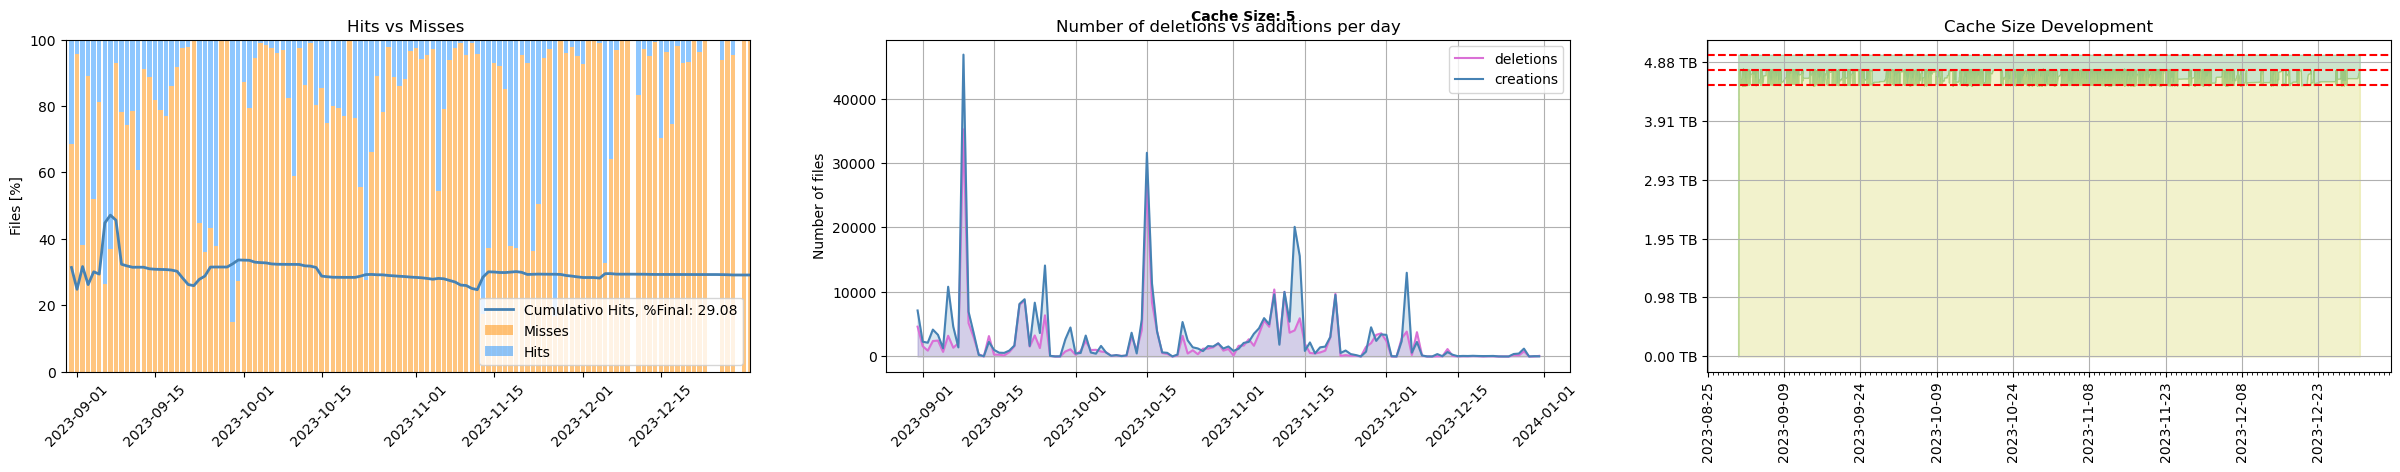

16.097705841064453 segundos, cache_size: 5120
Start time 2024-02-27 11:56:46.266263 Tamaño: 10


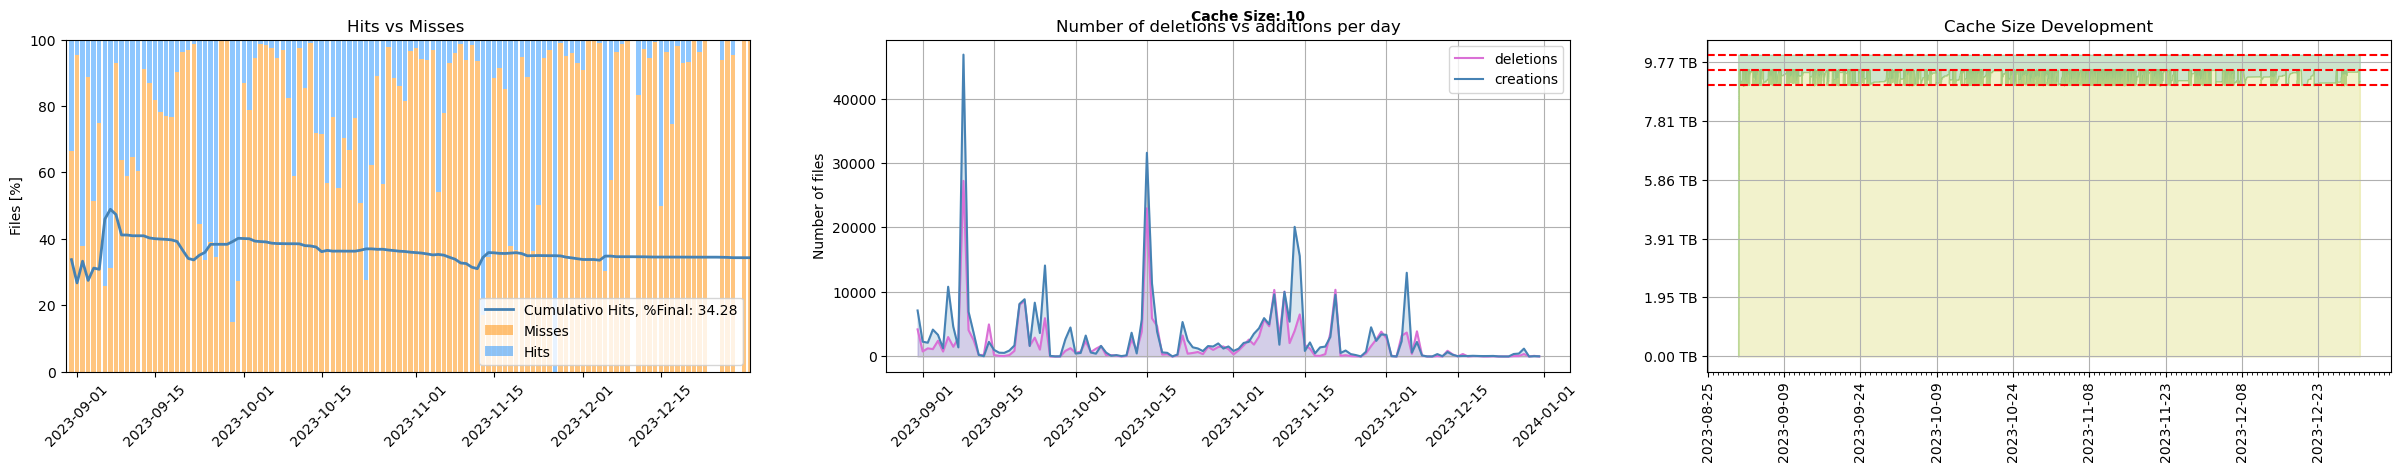

21.998751878738403 segundos, cache_size: 10240
Start time 2024-02-27 11:57:08.265131 Tamaño: 15


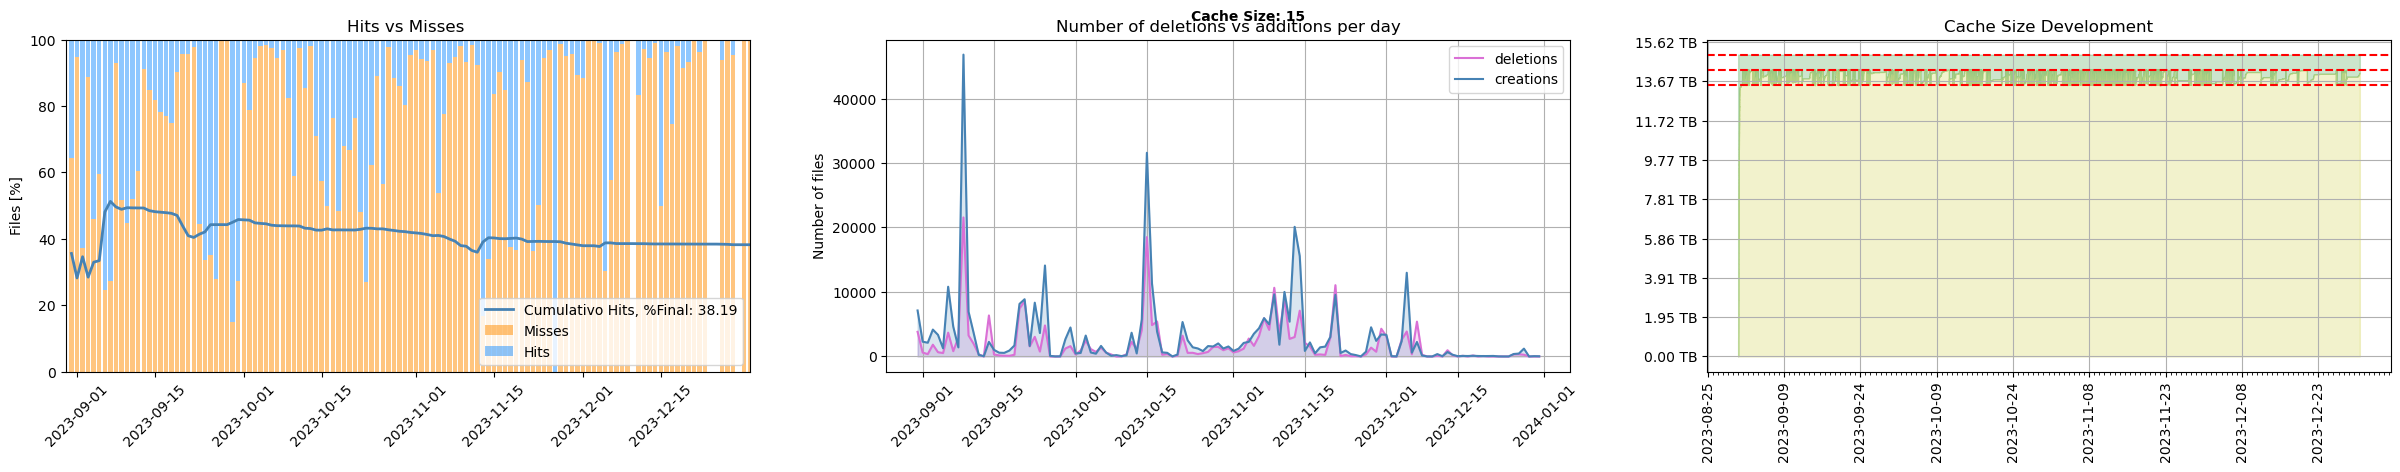

25.449490547180176 segundos, cache_size: 15360
Start time 2024-02-27 11:57:33.714741 Tamaño: 20


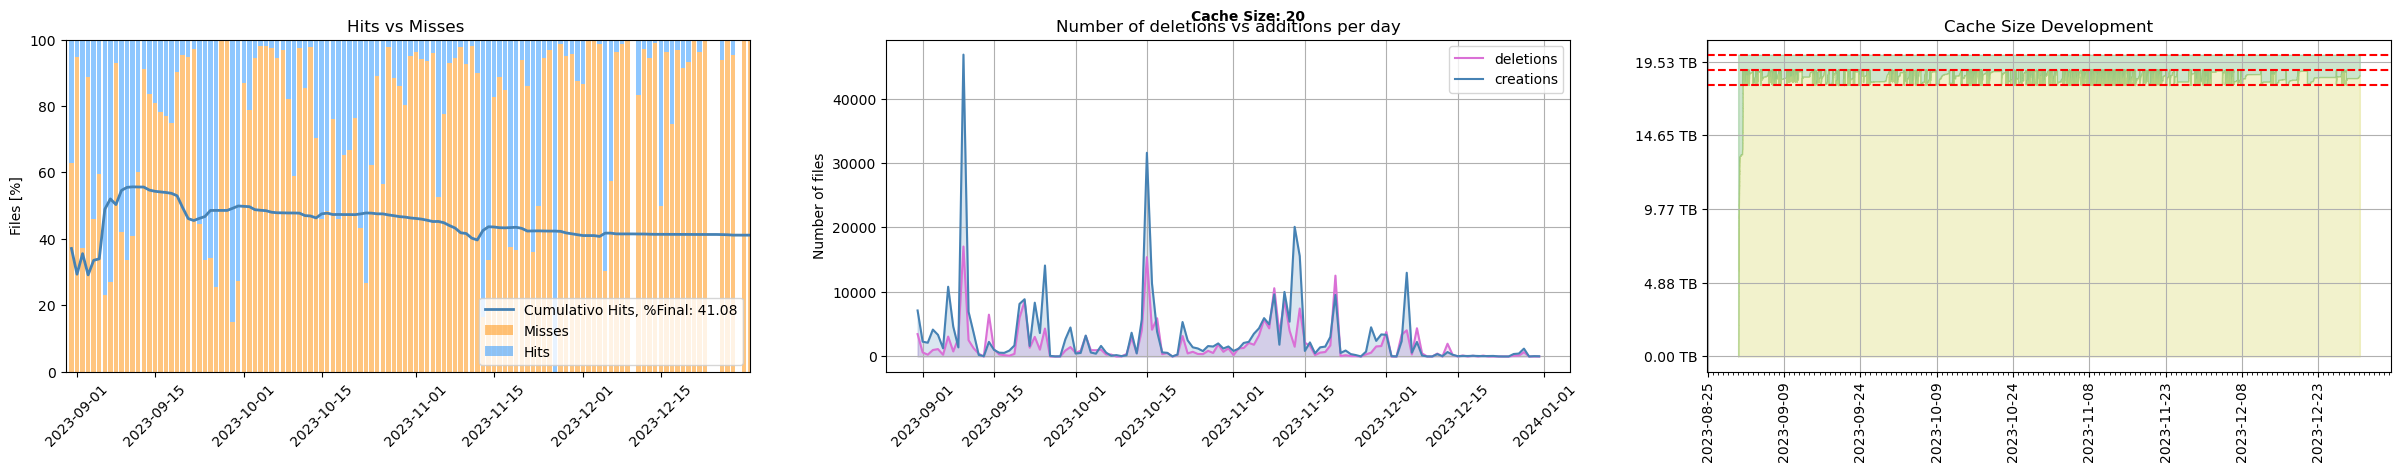

27.962727069854736 segundos, cache_size: 20480
Start time 2024-02-27 11:58:01.677594 Tamaño: 25


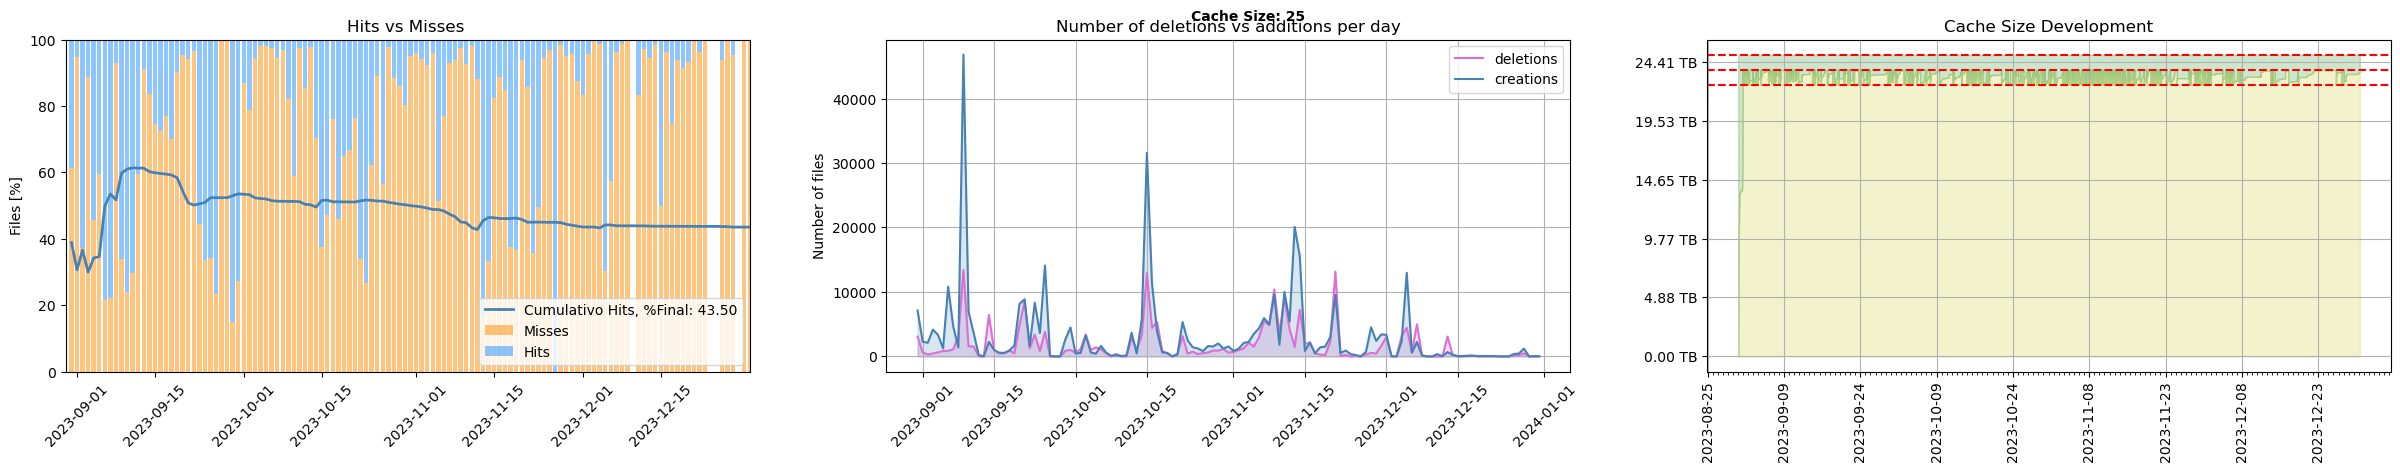

27.79901933670044 segundos, cache_size: 25600
Start time 2024-02-27 11:58:29.476734 Tamaño: 30


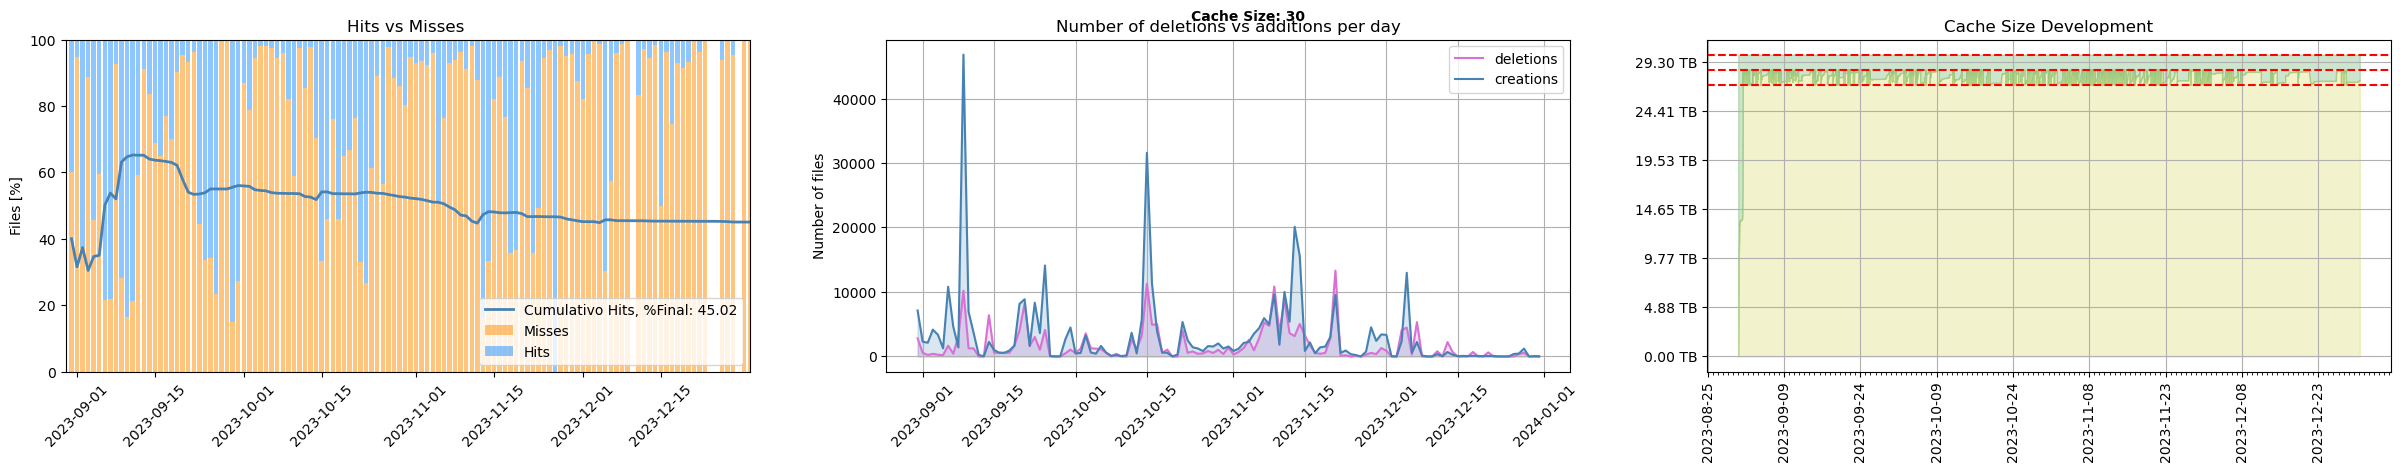

31.76949405670166 segundos, cache_size: 30720
Start time 2024-02-27 11:59:01.246349 Tamaño: 35


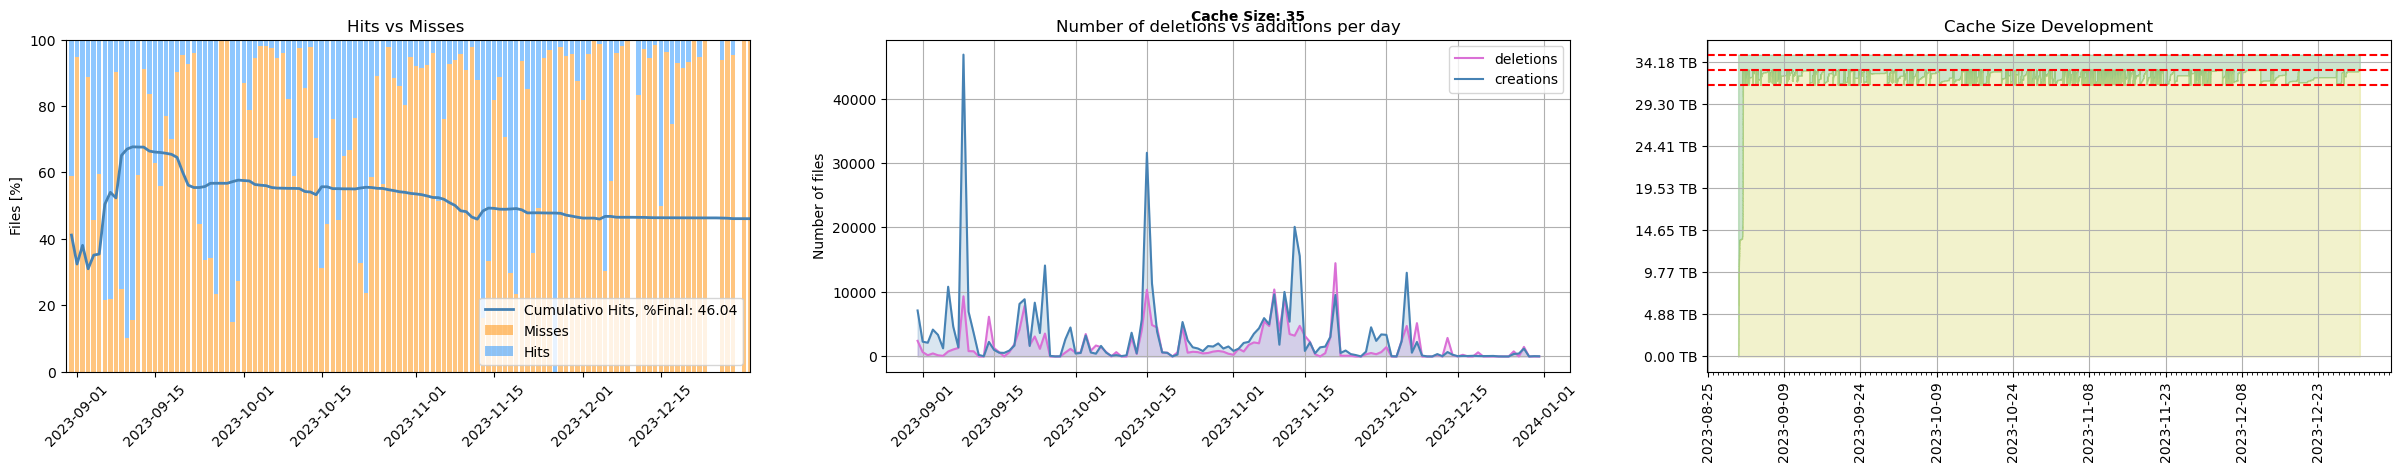

31.50747323036194 segundos, cache_size: 35840
Start time 2024-02-27 11:59:32.753952 Tamaño: 40


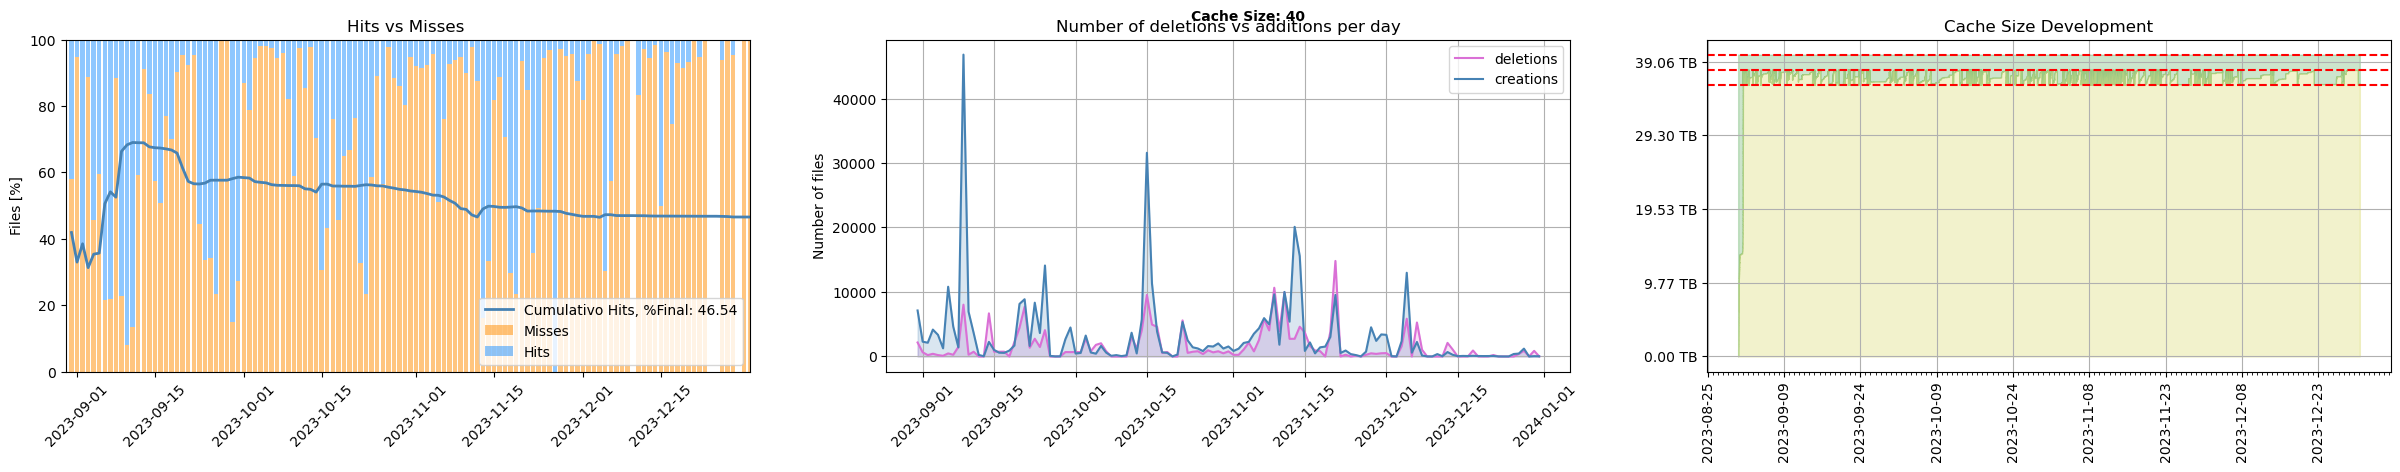

36.496208906173706 segundos, cache_size: 40960
Start time 2024-02-27 12:00:09.250275 Tamaño: 45


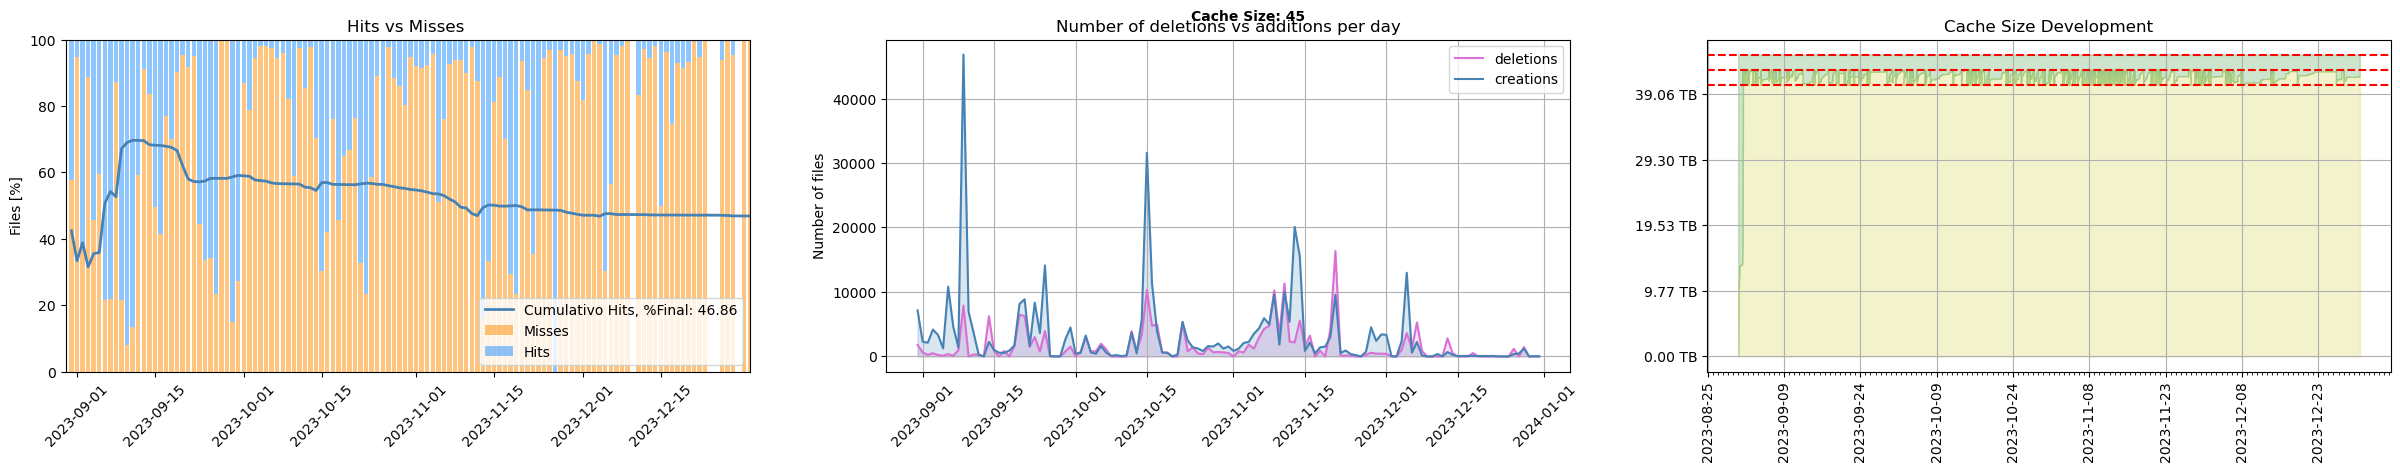

38.636685848236084 segundos, cache_size: 46080
Start time 2024-02-27 12:00:47.887066 Tamaño: 50


KeyboardInterrupt: 

In [25]:
pct_max = 0.95 #hasta cuanto se llena
pct_delete = 0.9 #cuando se llena hasta cuanto la bajo (del total)

start_date, end_date = date(2023, 6, 1), date(2024, 1, 31)
cache_sizes = [i for i in range(1800, 2005, 5)][1:]

rate_hit_miss_dict = {}
rate_hit_dict= {}
rate_miss_dict = {}
rate_cociente_salida_entrada_dict = {}
cumulativo_final_dict = {}

START_TIME = time.time()
for i,(mm,yyyy) in enumerate(get_sliding_windows(start_date,end_date)):
    start_month, start_year = mm[0], yyyy[0]
    end_month, end_year = mm[-1], yyyy[-1]
    #print(sw)
    sw_start_date, sw_end_date = date(start_year, start_month, 1), date(end_year, end_month, 1) - timedelta(days=1)
    if i == 0:
        sw_start_date -= timedelta(days=1)
    
    dates = pd.date_range(start=sw_start_date, end=sw_end_date).date 
    print(f"{start_month}_{start_year}-{end_month}_{end_year}")
    print("From",sw_start_date,"To",sw_end_date)
    print("Número de dias:",len(dates),"\n")
    
    plot_file_path =  f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/'
    doc_filename = f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/plot_sw{i}.html'
    doc = open(doc_filename, 'r+')
    
    try:
        last_plot_size = int(documento.readlines()[-3][10:].split("<")[0])
    except: #vacio
        cache_sizes = [i for i in range(0, 2005, 5)][1:]
    else:
        if last_plot_size == 2000:
            pass
        cache_sizes = [i for i in range(last_plot_size, 2005, 5)][1:]
        
    data3 = data2[data2["Dia"].isin(dates)]
    
    for size in cache_sizes:
        print("Start time",datetime.now(),"Tamaño:",size)
        start = time.time()
        SIZE = size * 1024 #180 teras pasados a gigas

        cache_restart = SIZE * pct_delete
        max_cache = SIZE * pct_max

        _HistoricoAdditions, _HistoricoDeletions, _HistoricoStaticDia = cache_per(data3,size,dates)

        ADDITIONSdata = create_ADDITIONSdata(_HistoricoAdditions)
        DELETIONSdata = create_DELETIONSdata(_HistoricoDeletions)
        STATICDIA =  create_STATICDIA(_HistoricoStaticDia)

        DELETIONSdata_byday = DELETIONSdata.groupby('Dia')
        ADDITIONSdata_byday = ADDITIONSdata.groupby('Dia')
        STATICDIA_byday = STATICDIA.groupby('Dia')

        #plots para cada cache_size
        n_rows = 1
        n_cols = 3
        figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
        #plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.subplots_adjust(hspace=0.4)
        # axis = axis.flatten()
        #figure.delaxes(axis[-1])

        cumulativo_final = hit_vs_miss_plot(ADDITIONSdata_byday, axis[0],dates)
        #_, _ = hit_vs_miss_plot(ADDITIONSdata_byday, axis[1],True)
        plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday,dates, axis[1])
       # nueva_metrica = plot_size_times_days_files(STATICDIA_byday, ADDITIONSdata_byday, axis[2])
        plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis[2])
        #num_of_static_files(ADDITIONSdata_byday, STATICDIA, axis[3])
        #plot_size_times_days_files_cumulativo(STATICDIA_byday, ADDITIONSdata_byday, axis[4])

        plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
        plt.subplots_adjust(top=0.94)
        plt.show()
        
        plot_filename = f'/nfs/pic.es/user/p/pserrano/SW_PLOTS/SW{i}/plot_sw{i}_sz{size}.png'
        
        plt.savefig(plot_filename, format='png')
        plt.close()

        doc.write(f'<h2>Tamaño {i}</h2>\n')
        doc.write(f'<img src="{plot_filename}" alt="Plot {i}">\n\n')

        list_size = np.array(ADDITIONSdata.groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        hits_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"] == False].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        miss_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"]].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)

        rate_hit_miss_dict[size] = get_max_mean(list_size) #igual a salida
        rate_hit_dict[size] = get_max_mean(hits_list_size)
        rate_miss_dict[size] = get_max_mean(miss_list_size) #igual a entrada
        rate_cociente_salida_entrada_dict[size] = rate_hit_miss_dict[size]/rate_miss_dict[size]
        cumulativo_final_dict[size] = cumulativo_final

        with open(f'/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_{start_month}_{start_year}-{end_month}_{end_year}.pkl', 'wb') as archivo_pickle:
            pickle.dump((rate_hit_miss_dict,rate_hit_dict,rate_miss_dict,rate_cociente_salida_entrada_dict,cumulativo_final_dict), archivo_pickle)
        #with open('/nfs/pic.es/user/p/pserrano/aditions_antes.pkl', 'wb') as archivo_pickle:
         #   pickle.dump(DELETIONSdata, archivo_pickle) 

        end = time.time() - start
        print(end,"segundos, cache_size:",SIZE)

TOTAL_TIME = time.time() - START_TIME
print(f"Total Time: {TOTAL_TIME}")

In [ ]:
doc.close()

9_2023-1_2024
From 2023-08-31 To 2023-12-31
Número de dias: 122 

start time 2024-02-26 11:53:34.084458


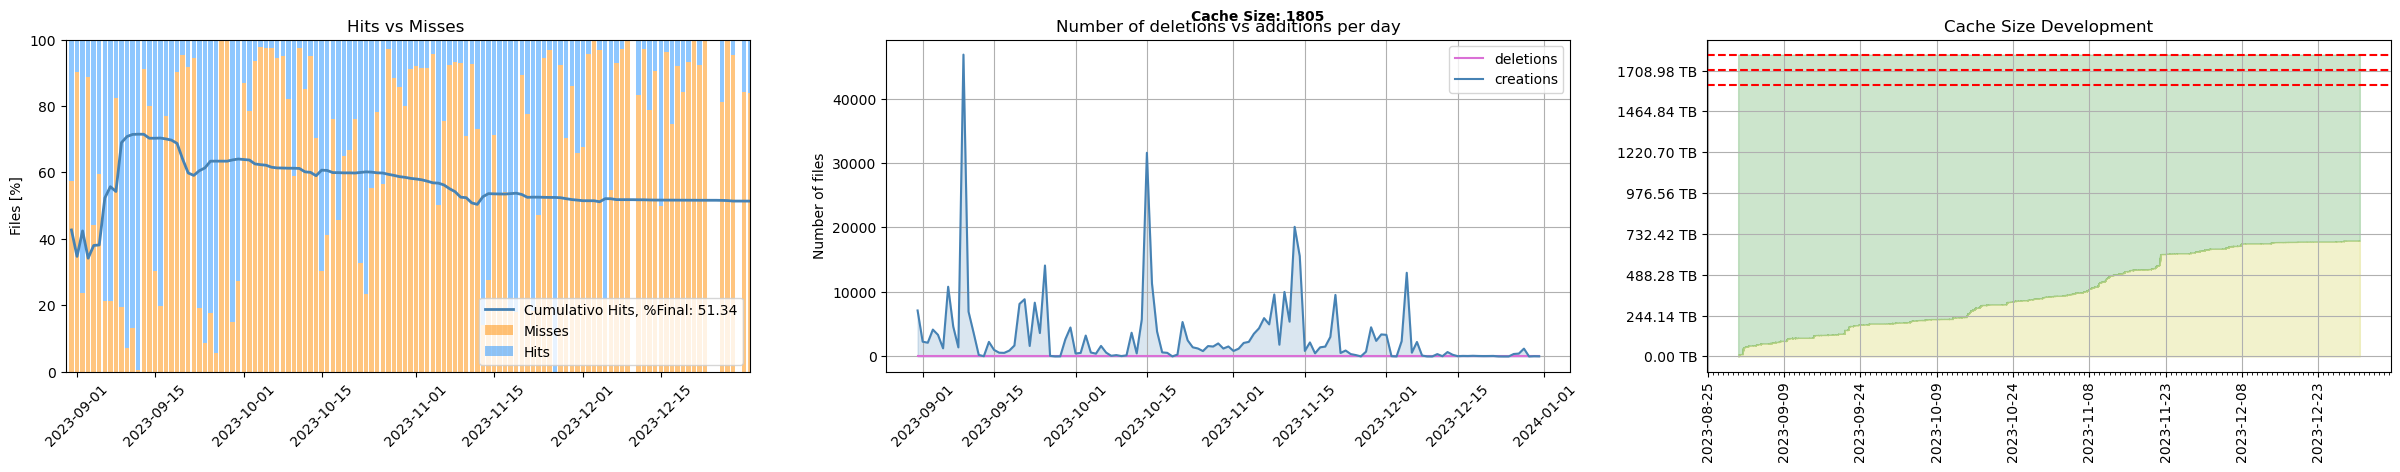

206.545814037323 segundos, cache_size: 1848320
start time 2024-02-26 11:57:00.630406


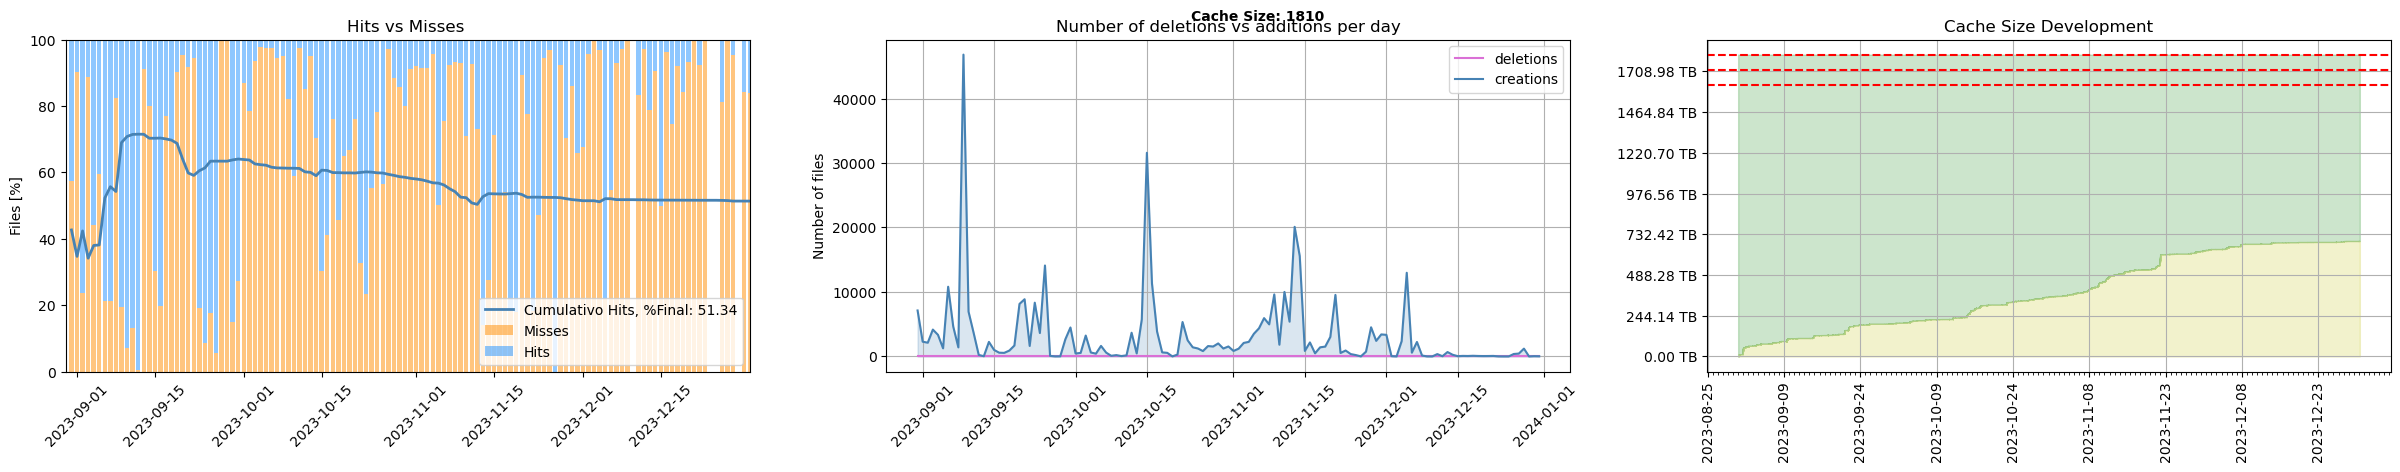

196.46822476387024 segundos, cache_size: 1853440
start time 2024-02-26 12:00:17.098730


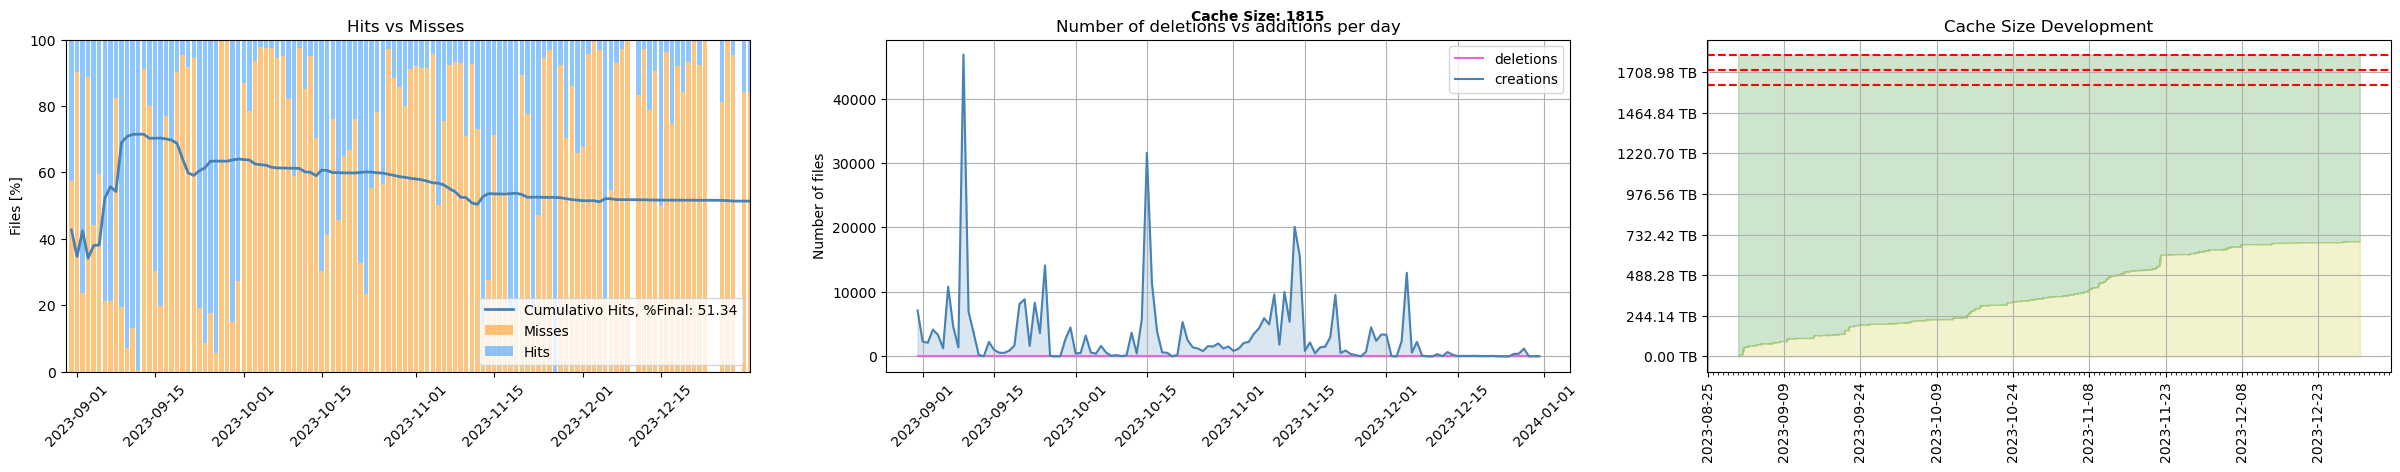

195.98204898834229 segundos, cache_size: 1858560
start time 2024-02-26 12:03:33.080909


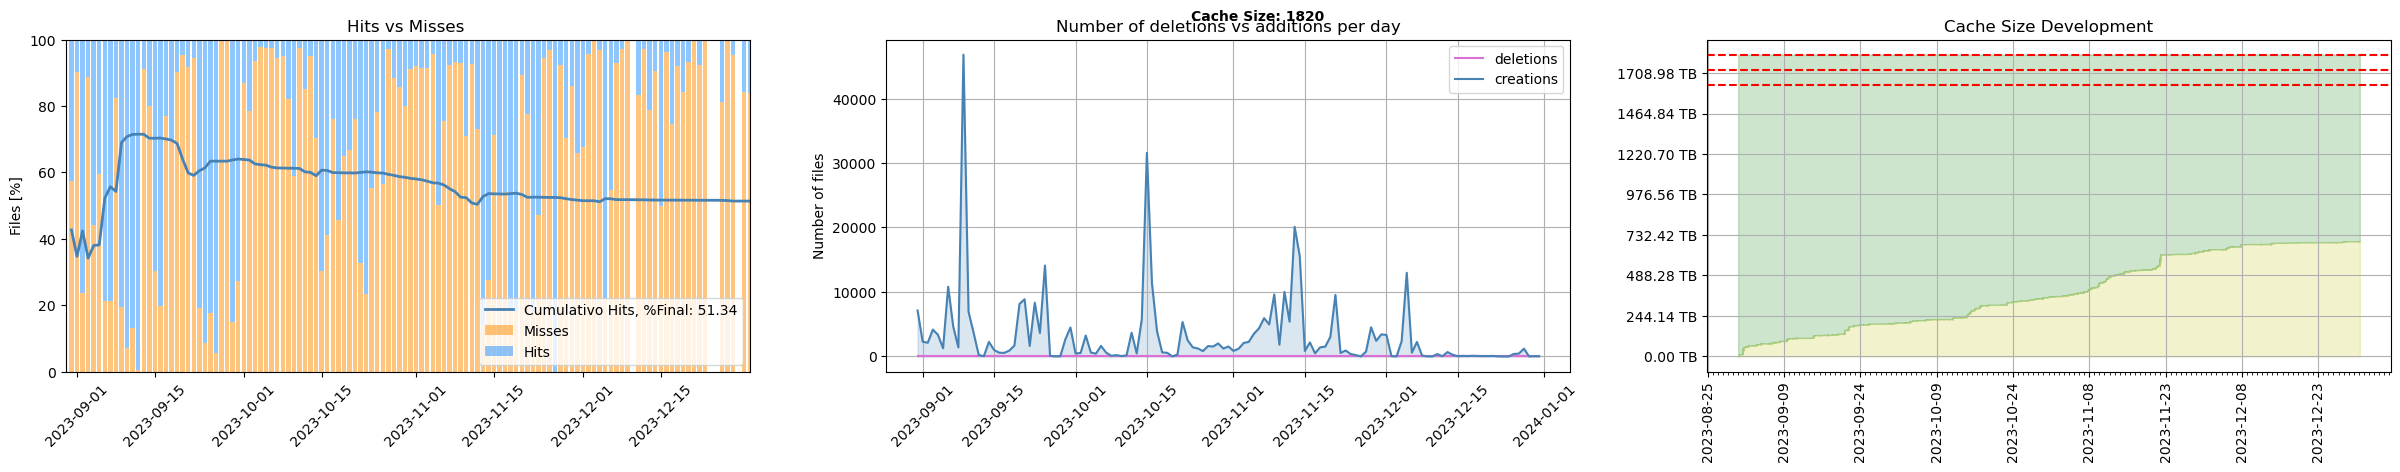

204.01704931259155 segundos, cache_size: 1863680
start time 2024-02-26 12:06:57.098046


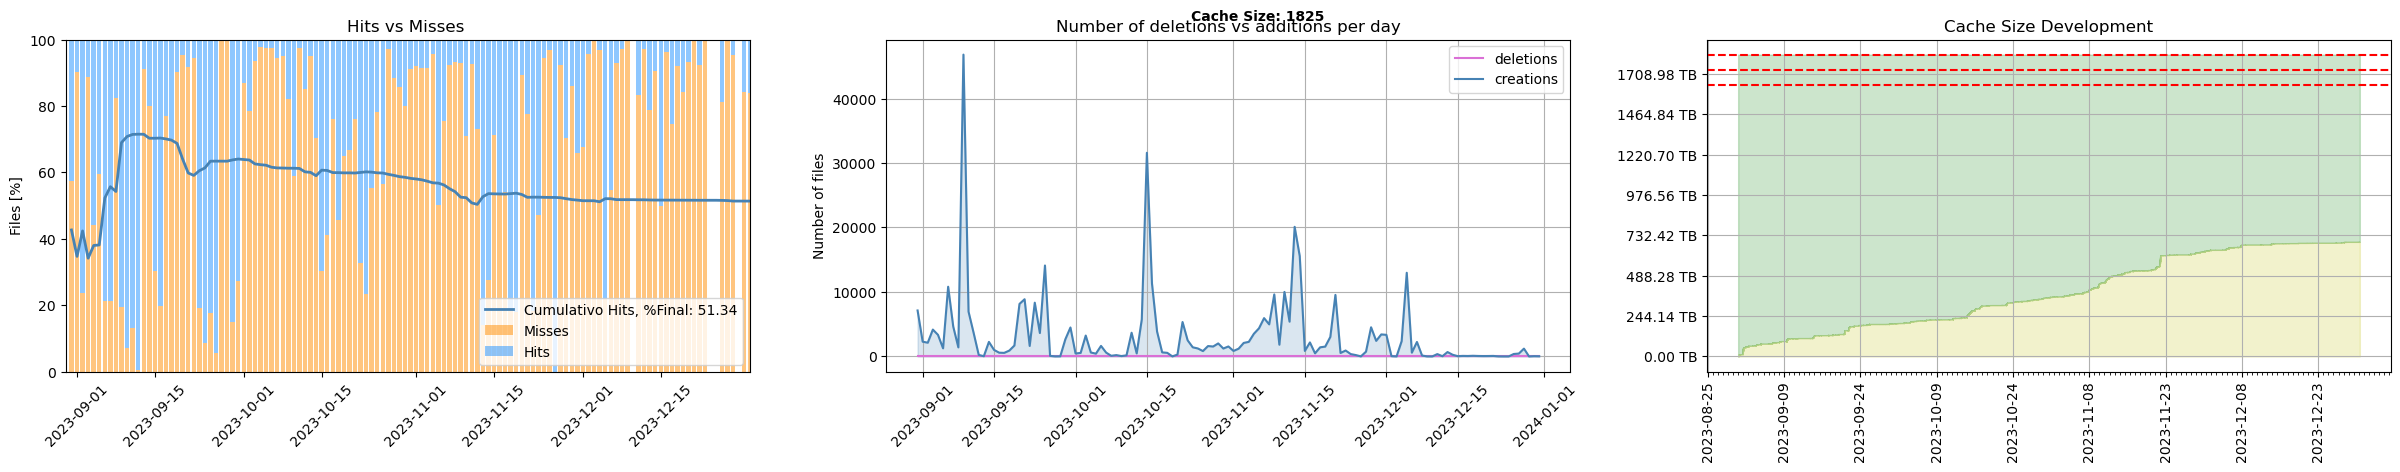

203.5939962863922 segundos, cache_size: 1868800
start time 2024-02-26 12:10:20.692130


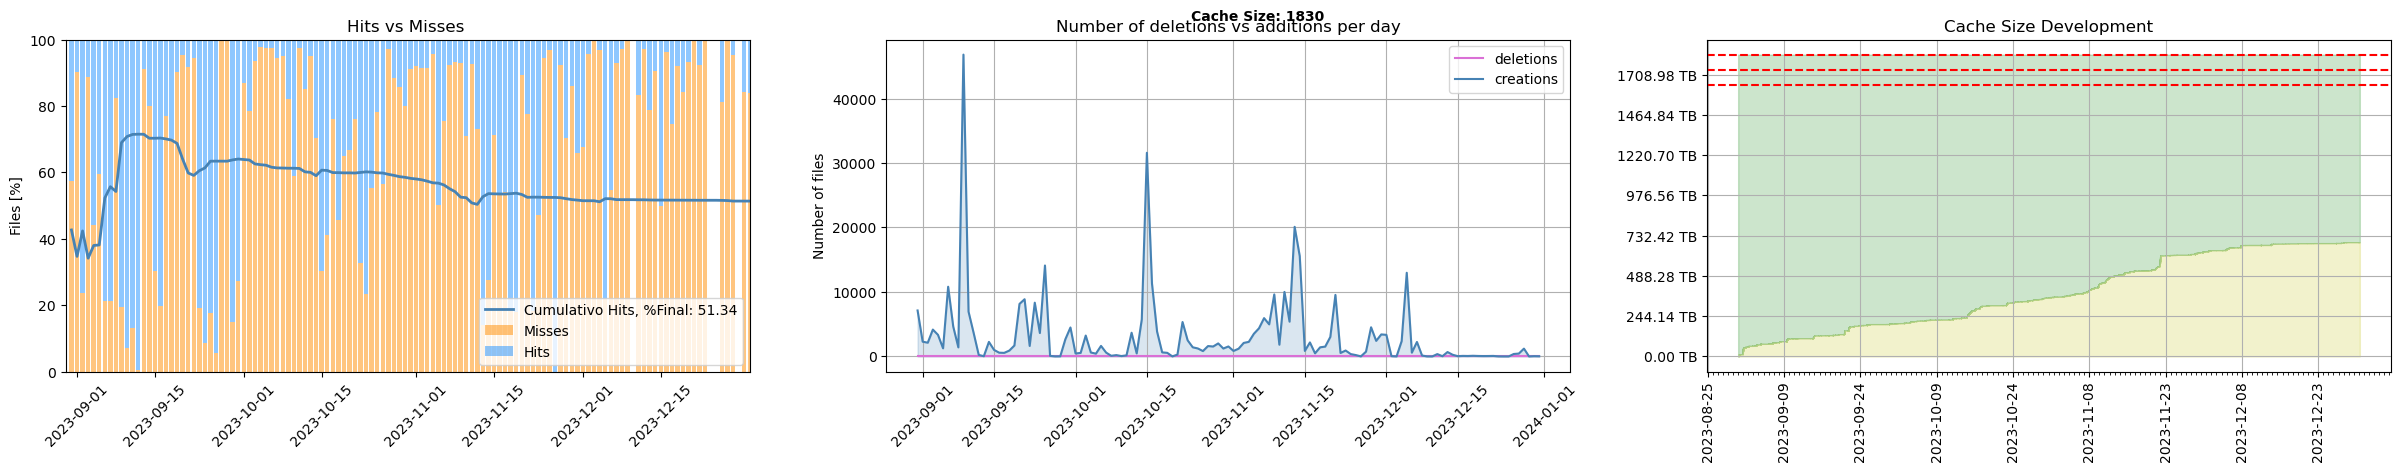

189.9396915435791 segundos, cache_size: 1873920
start time 2024-02-26 12:13:30.631932


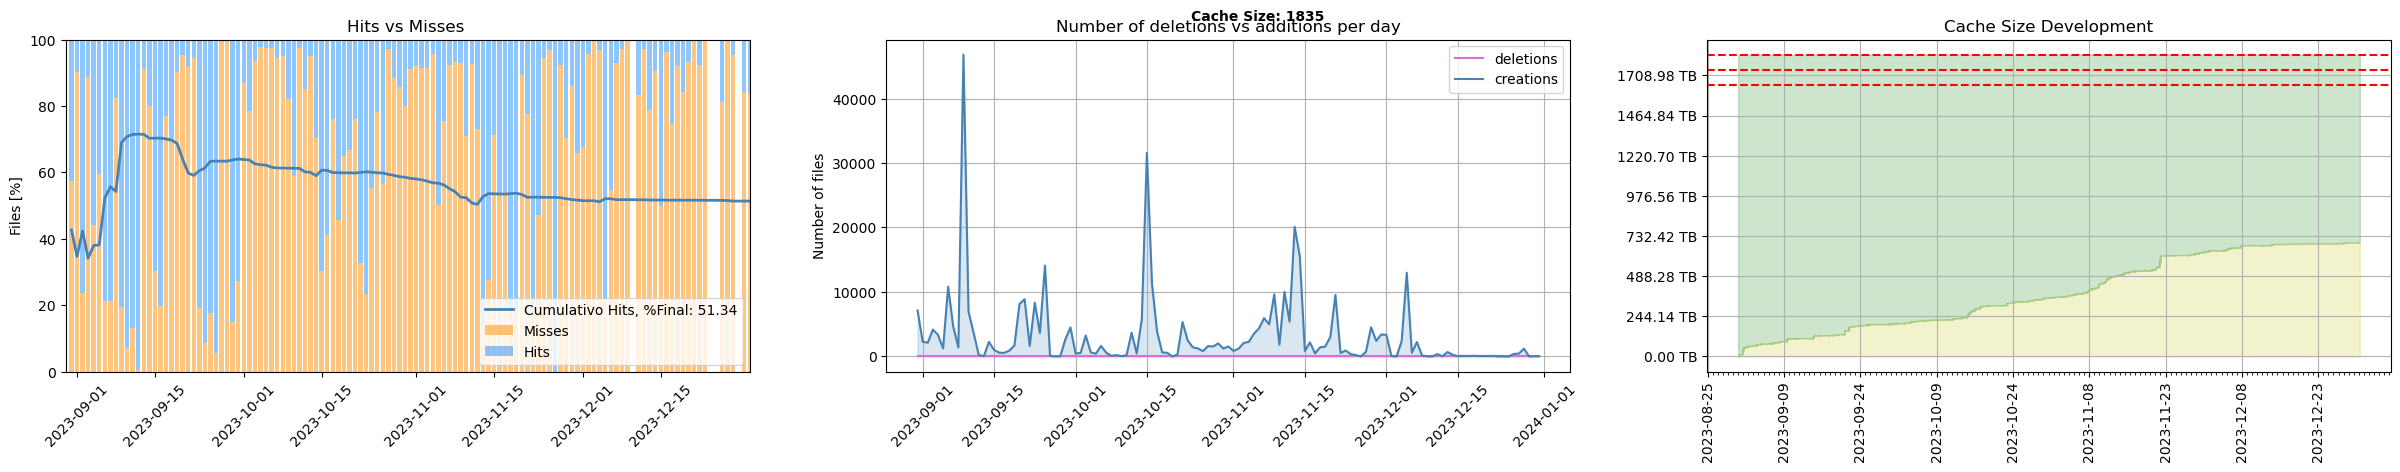

192.3460292816162 segundos, cache_size: 1879040
start time 2024-02-26 12:16:42.978054


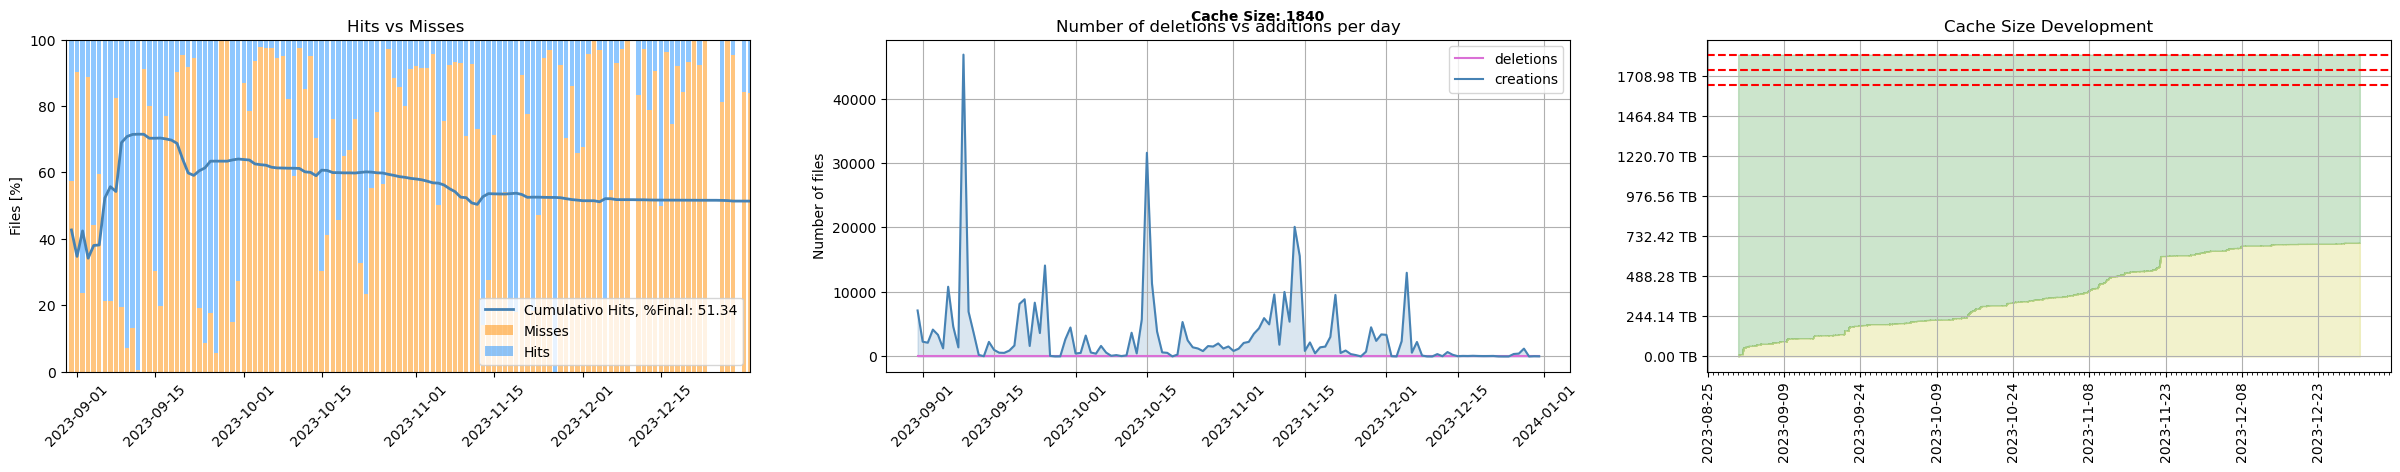

200.8330569267273 segundos, cache_size: 1884160
start time 2024-02-26 12:20:03.811214


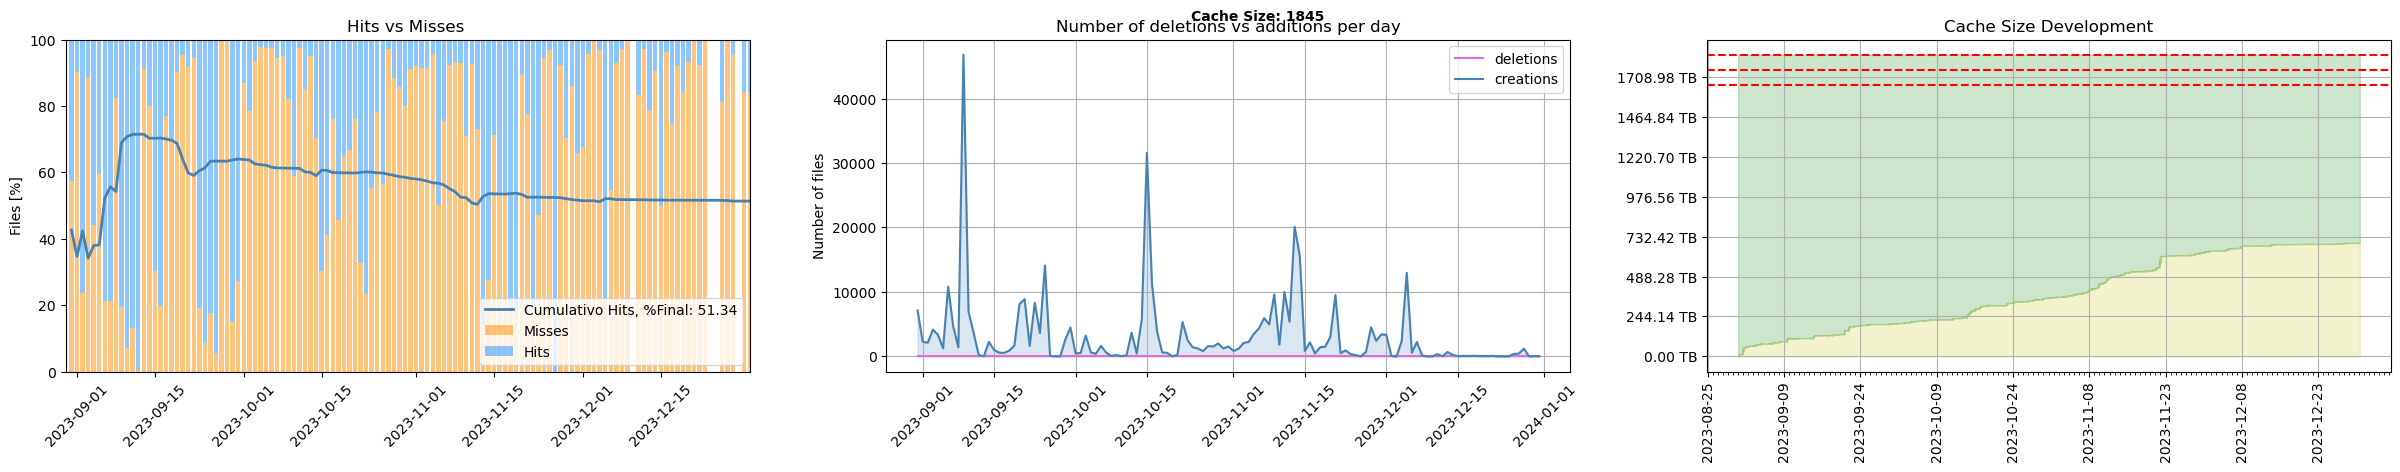

200.60838150978088 segundos, cache_size: 1889280
start time 2024-02-26 12:23:24.419706


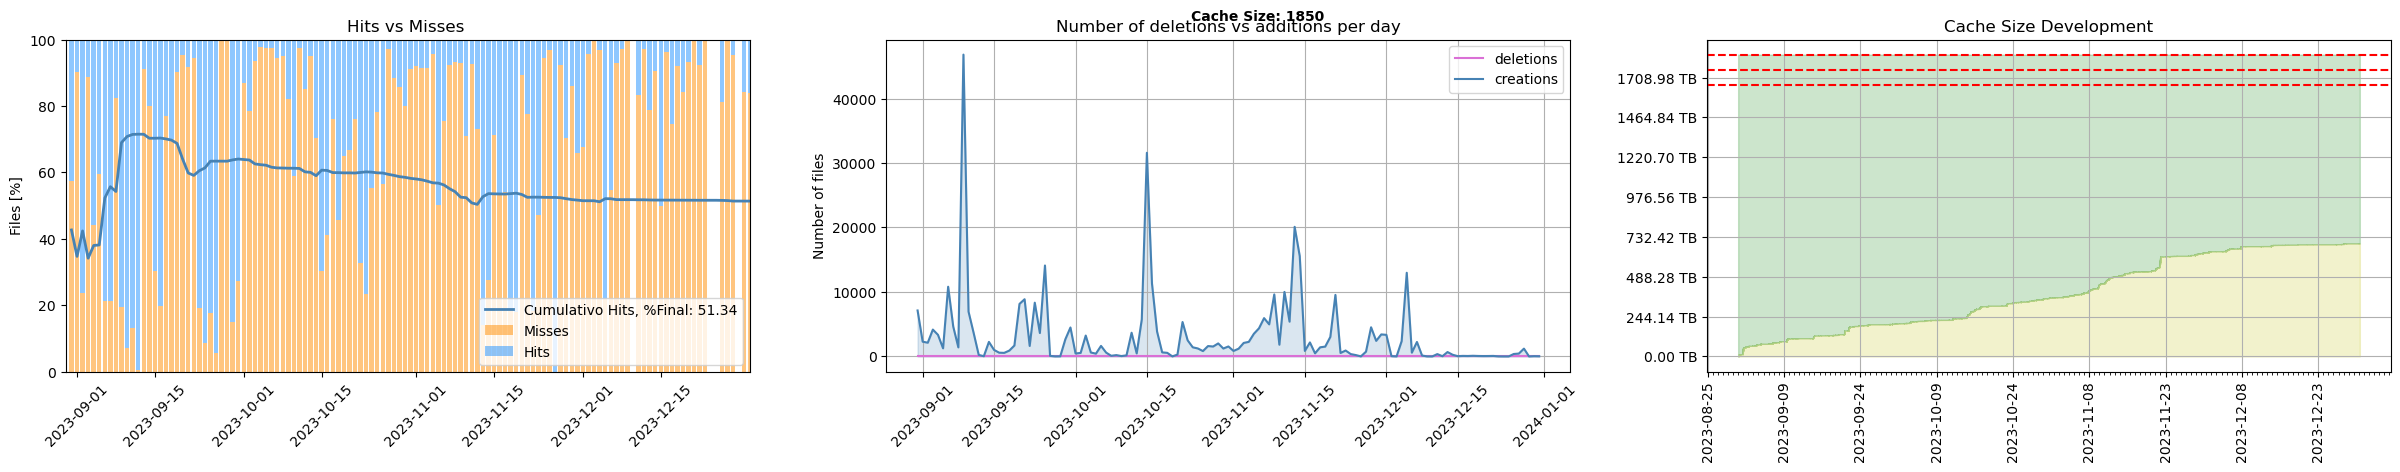

192.324059009552 segundos, cache_size: 1894400
start time 2024-02-26 12:26:36.743864


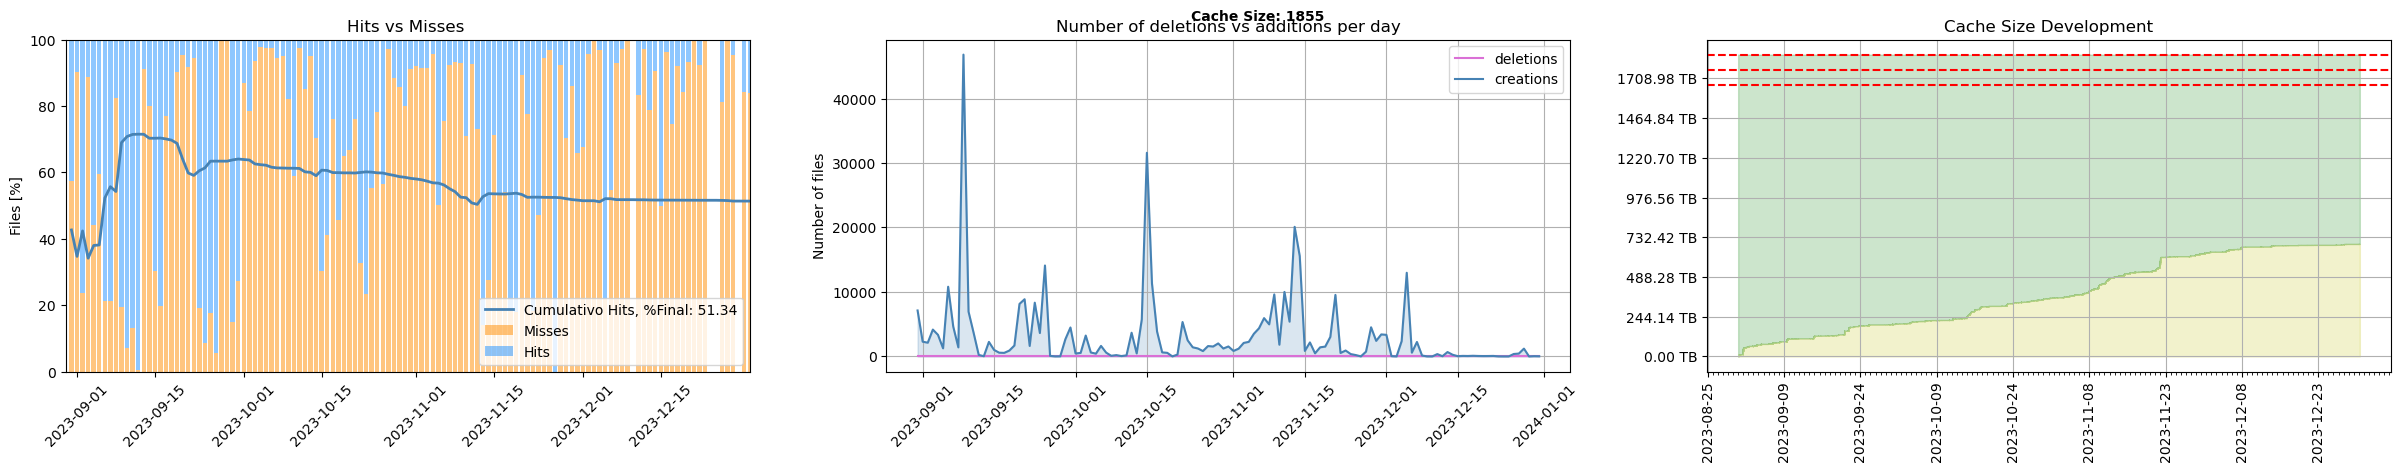

201.40361404418945 segundos, cache_size: 1899520
start time 2024-02-26 12:29:58.147582


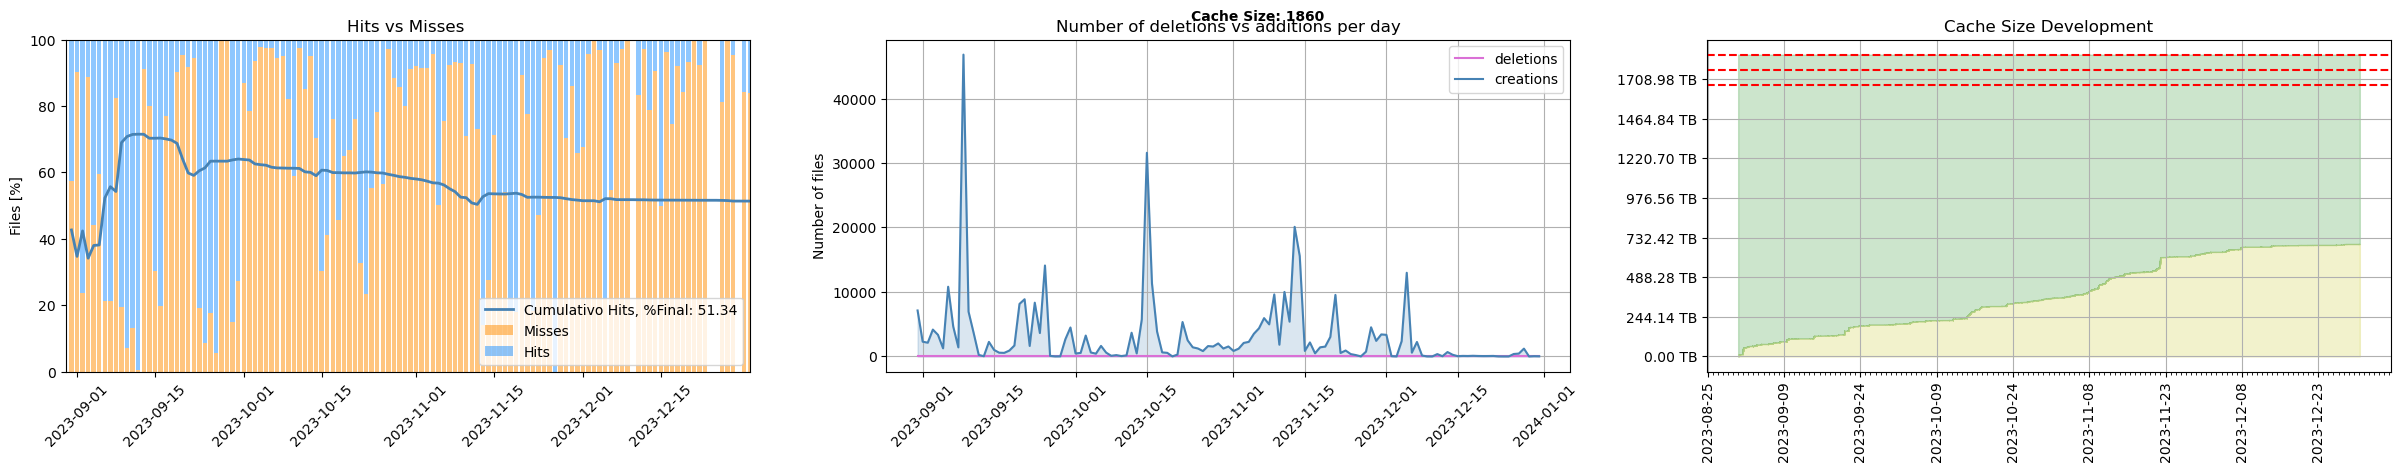

199.31664490699768 segundos, cache_size: 1904640
start time 2024-02-26 12:33:17.464325


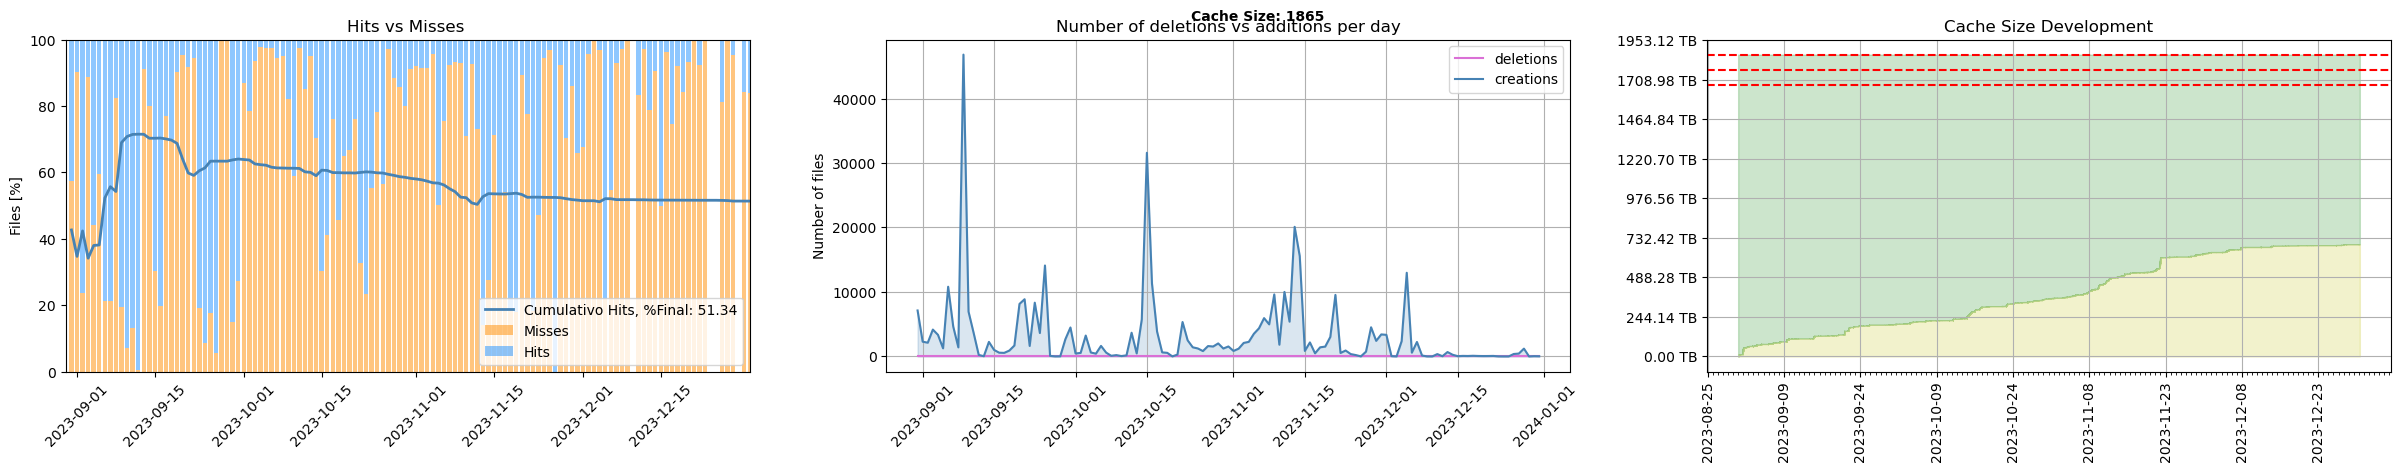

198.23227453231812 segundos, cache_size: 1909760
start time 2024-02-26 12:36:35.696701


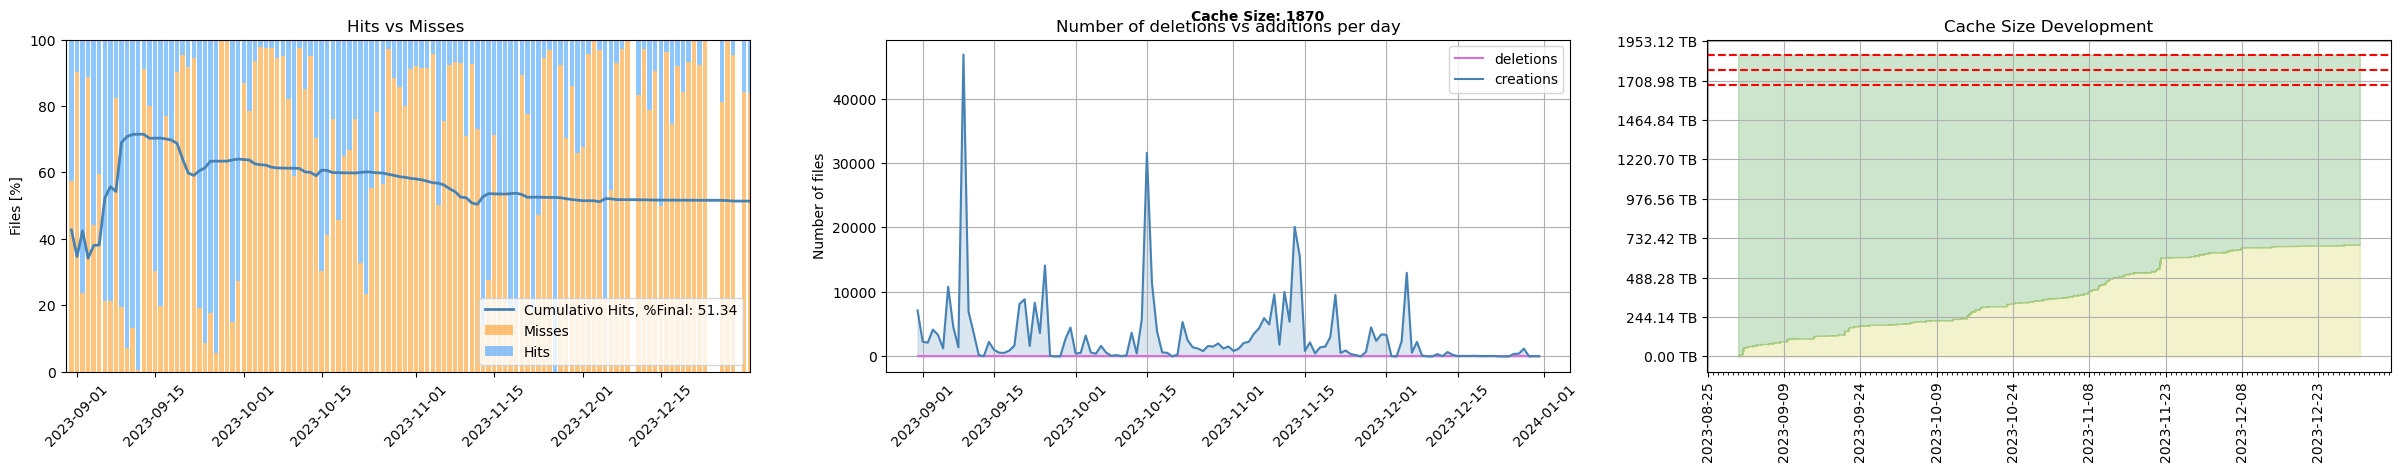

195.5079951286316 segundos, cache_size: 1914880
start time 2024-02-26 12:39:51.204796


KeyboardInterrupt: 

In [121]:
pct_max = 0.95 #hasta cuanto se llena
pct_delete = 0.9 #cuando se llena hasta cuanto la bajo (del total)

start_date, end_date = date(2023, 6, 1), date(2024, 1, 31)
cache_sizes = [i for i in range(1800, 2005, 5)][1:]

rate_hit_miss_dict = {}
rate_hit_dict= {}
rate_miss_dict = {}
rate_cociente_salida_entrada_dict = {}
cumulativo_final_dict = {}

START_TIME = time.time()
for i,(mm,yyyy) in enumerate(get_sliding_windows(start_date,end_date)[-1:]):
    start_month, start_year = mm[0], yyyy[0]
    end_month, end_year = mm[-1], yyyy[-1]
    #print(sw)
    sw_start_date, sw_end_date = date(start_year, start_month, 1), date(end_year, end_month, 1) - timedelta(days=1)
    if i == 0:
        sw_start_date -= timedelta(days=1)
    
    dates = pd.date_range(start=sw_start_date, end=sw_end_date).date 
    print(f"{start_month}_{start_year}-{end_month}_{end_year}")
    print("From",sw_start_date,"To",sw_end_date)
    print("Número de dias:",len(dias),"\n")
    
    data3 = data2[data2["Dia"].isin(dates)]
    
    for size in cache_sizes:
        print("start time",datetime.now())
        start = time.time()
        SIZE = size * 1024 #180 teras pasados a gigas

        cache_restart = SIZE * pct_delete
        max_cache = SIZE * pct_max

        _HistoricoAdditions, _HistoricoDeletions, _HistoricoStaticDia = cache_per(data3,size,dates)

        ADDITIONSdata = create_ADDITIONSdata(_HistoricoAdditions)
        DELETIONSdata = create_DELETIONSdata(_HistoricoDeletions)
        STATICDIA =  create_STATICDIA(_HistoricoStaticDia)

        DELETIONSdata_byday = DELETIONSdata.groupby('Dia')
        ADDITIONSdata_byday = ADDITIONSdata.groupby('Dia')
        STATICDIA_byday = STATICDIA.groupby('Dia')

        #plots para cada cache_size
        n_rows = 1
        n_cols = 3
        figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
        #plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.subplots_adjust(hspace=0.4)
        # axis = axis.flatten()
        #figure.delaxes(axis[-1])

        cumulativo_final = hit_vs_miss_plot(ADDITIONSdata_byday, axis[0],dates)
        #_, _ = hit_vs_miss_plot(ADDITIONSdata_byday, axis[1],True)
        plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday,dates, axis[1])
       # nueva_metrica = plot_size_times_days_files(STATICDIA_byday, ADDITIONSdata_byday, axis[2])
        plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis[2])
        #num_of_static_files(ADDITIONSdata_byday, STATICDIA, axis[3])
        #plot_size_times_days_files_cumulativo(STATICDIA_byday, ADDITIONSdata_byday, axis[4])

        plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
        plt.subplots_adjust(top=0.94)
        plt.show()

        hits_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"] == False].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        miss_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"]].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)

        rate_hit_miss_dict[size] = get_max_mean(list_size) #igual a salida
        rate_hit_dict[size] = get_max_mean(hits_list_size)
        rate_miss_dict[size] = get_max_mean(miss_list_size) #igual a entrada
        rate_cociente_salida_entrada_dict[size] = rate_hit_miss_dict[size]/rate_miss_dict[size]
        cumulativo_final_dict[size] = cumulativo_final

        with open(f'/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_{start_month}_{start_year}-{end_month}_{end_year}.pkl', 'wb') as archivo_pickle:
            pickle.dump((rate_hit_miss_dict,rate_hit_dict,rate_miss_dict,rate_cociente_salida_entrada_dict,cumulativo_final_dict), archivo_pickle)
        #with open('/nfs/pic.es/user/p/pserrano/aditions_antes.pkl', 'wb') as archivo_pickle:
         #   pickle.dump(DELETIONSdata, archivo_pickle) 

        end = time.time() - start
        print(end,"segundos, cache_size:",SIZE)

TOTAL_TIME = time.time() - START_TIME
print(f"Total Time: {TOTAL_TIME}")

In [ ]:
pct_max = 0.95 #hasta cuanto se llena
pct_delete = 0.9 #cuando se llena hasta cuanto la bajo (del total)

start_date, end_date = date(2023, 6, 1), date(2024, 1, 31)
cache_sizes = [i for i in range(1800, 2005, 5)][1:]

rate_hit_miss_dict = {}
rate_hit_dict= {}
rate_miss_dict = {}
rate_cociente_salida_entrada_dict = {}
cumulativo_final_dict = {}

START_TIME = time.time()
for i,(mm,yyyy) in enumerate(get_sliding_windows(start_date,end_date)[-1:]):
    start_month, start_year = mm[0], yyyy[0]
    end_month, end_year = mm[-1], yyyy[-1]
    #print(sw)
    sw_start_date, sw_end_date = date(start_year, start_month, 1), date(end_year, end_month, 1) - timedelta(days=1)
    if i == 0:
        sw_start_date -= timedelta(days=1)
    
    dates = pd.date_range(start=sw_start_date, end=sw_end_date).date 
    print(f"{start_month}_{start_year}-{end_month}_{end_year}")
    print("From",sw_start_date,"To",sw_end_date)
    print("Número de dias:",len(dias),"\n")
    
    data3 = data2[data2["Dia"].isin(dates)]
    
    for size in cache_sizes:
        print("start time",datetime.now())
        start = time.time()
        SIZE = size * 1024 #180 teras pasados a gigas

        cache_restart = SIZE * pct_delete
        max_cache = SIZE * pct_max

        _HistoricoAdditions, _HistoricoDeletions, _HistoricoStaticDia = cache_per(data3,size,dates)

        ADDITIONSdata = create_ADDITIONSdata(_HistoricoAdditions)
        DELETIONSdata = create_DELETIONSdata(_HistoricoDeletions)
        STATICDIA =  create_STATICDIA(_HistoricoStaticDia)

        DELETIONSdata_byday = DELETIONSdata.groupby('Dia')
        ADDITIONSdata_byday = ADDITIONSdata.groupby('Dia')
        STATICDIA_byday = STATICDIA.groupby('Dia')

        #plots para cada cache_size
        n_rows = 1
        n_cols = 3
        figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
        #plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.subplots_adjust(hspace=0.4)
        # axis = axis.flatten()
        #figure.delaxes(axis[-1])

        cumulativo_final = hit_vs_miss_plot(ADDITIONSdata_byday, axis[0],dates)
        #_, _ = hit_vs_miss_plot(ADDITIONSdata_byday, axis[1],True)
        plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday,dates, axis[1])
       # nueva_metrica = plot_size_times_days_files(STATICDIA_byday, ADDITIONSdata_byday, axis[2])
        plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis[2])
        #num_of_static_files(ADDITIONSdata_byday, STATICDIA, axis[3])
        #plot_size_times_days_files_cumulativo(STATICDIA_byday, ADDITIONSdata_byday, axis[4])

        plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
        plt.subplots_adjust(top=0.94)
        plt.show()

        hits_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"] == False].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)
        miss_list_size =  np.array(ADDITIONSdata[ADDITIONSdata["Miss"]].groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reindex(dates, fill_value=0)) /(3600*24)

        rate_hit_miss_dict[size] = get_max_mean(list_size) #igual a salida
        rate_hit_dict[size] = get_max_mean(hits_list_size)
        rate_miss_dict[size] = get_max_mean(miss_list_size) #igual a entrada
        rate_cociente_salida_entrada_dict[size] = rate_hit_miss_dict[size]/rate_miss_dict[size]
        cumulativo_final_dict[size] = cumulativo_final

        with open(f'/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_{start_month}_{start_year}-{end_month}_{end_year}.pkl', 'wb') as archivo_pickle:
            pickle.dump((rate_hit_miss_dict,rate_hit_dict,rate_miss_dict,rate_cociente_salida_entrada_dict,cumulativo_final_dict), archivo_pickle)
        #with open('/nfs/pic.es/user/p/pserrano/aditions_antes.pkl', 'wb') as archivo_pickle:
         #   pickle.dump(DELETIONSdata, archivo_pickle) 

        end = time.time() - start
        print(end,"segundos, cache_size:",SIZE)

TOTAL_TIME = time.time() - START_TIME
print(f"Total Time: {TOTAL_TIME}")

9_2023-1_2024
From 2023-08-31 To 2023-12-31
Número de dias: 122 

start time 2024-02-26 11:53:34.084458


In [120]:
import subprocess

In [117]:
len(miss_list_size)

123

In [108]:
hits_list_size.sort()
len(hits_list_size)

119

In [106]:
np.array_equal(a,hits_list_size)

False

In [ ]:
n_hits_miss = ADDITIONSdata_byday['Miss'].size().reindex(all_dates, fill_value=0) #conteo de cuantos por dia

    n_miss = ADDITIONSdata_byday['Miss'].sum().reindex(all_dates, fill_value=0) #Cuantos true

In [91]:
a = np.array(ADDITIONSdata_byday['Tamano'].sum().reindex(dates, fill_value=0))/(3600*24)
(a == 0).sum()

4

In [92]:
len(a) - len(b)

4

In [88]:
b = np.array(ADDITIONSdata.groupby(ADDITIONSdata['Dia'])['Tamano'].sum().reset_index()["Tamano"]) /(3600*24)
b

array([9.59947685e-01, 1.34705880e-01, 1.40105312e-01, 1.02701195e-01,
       1.73184798e-01, 3.78861193e-02, 6.43632759e-01, 2.55476847e-01,
       9.45155793e-02, 1.11686246e+00, 1.70344509e-01, 8.96637427e-02,
       1.32453830e-02, 1.15694143e-03, 1.96030804e-01, 4.06501604e-02,
       2.23089114e-02, 1.63772780e-02, 2.78915465e-02, 5.65081237e-02,
       2.86157932e-01, 3.02929519e-01, 5.58314351e-02, 2.50413563e-01,
       1.05276171e-01, 4.09178703e-01, 2.67650197e-03, 7.16917592e-05,
       1.26839636e-03, 1.27998880e-01, 1.29428291e-01, 1.69554685e-02,
       2.95156487e-02, 9.82950723e-02, 3.23725734e-02, 3.26676418e-02,
       4.85456214e-02, 2.09588313e-02, 2.24487897e-03, 8.24878488e-03,
       3.07337361e-03, 4.01566626e-03, 1.18476521e-01, 3.22301680e-02,
       1.92293398e-01, 1.09883330e+00, 3.82511600e-01, 2.52497986e-01,
       4.14657951e-02, 3.85037202e-02, 1.65773052e-05, 1.40530003e-02,
       3.88016638e-01, 1.31834758e-01, 9.88369556e-02, 3.89925107e-02,
      

In [89]:
np.array_equal(a,b)

False

In [ ]:
57237/60/60

In [ ]:
import random 
random.shuffle(CACHE.items())

In [ ]:
a = list(CACHE.items())
for i,j in a:
    print(i, j)

In [ ]:
random.shuffle(a)
for i,j in a:
    print(i, j)

In [ ]:
def plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis):
    timestamp = [pd.Timestamp(i, unit='s') for i in ADDITIONSdata["TiempoUnix"]]

    axis.plot(timestamp, ADDITIONSdata["CacheSize"], linewidth=0.00001)
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    axis.xaxis.set_minor_locator(mdates.DayLocator())
    axis.grid(True)

    axis.axhline(y=SIZE, color='r', linestyle='--')
    axis.axhline(y=max_cache, color='r', linestyle='--')
    axis.axhline(y=cache_restart, color='r', linestyle='--')
    
    axis.set_title("Cache Size Development")
    axis.tick_params(axis='x',labelrotation=90)
    def terabytes_formatter(x, pos):
        return f'{x / (1024):.2f} TB'
    axis.yaxis.set_major_formatter(terabytes_formatter)

    axis.fill_between(timestamp, ADDITIONSdata["CacheSize"], color='y', alpha=0.2)
    axis.fill_between(timestamp, ADDITIONSdata["CacheSize"], SIZE, color='g', alpha=0.2)
    
n_rows = 1
n_cols = 1
figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
plt.subplots_adjust(hspace=0.4)

plot_matrix_sizes(a, SIZE, max_cache, cache_restart, axis)

plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
plt.subplots_adjust(top=0.94)
plt.show()

In [ ]:
set(dates) - set(ADDITIONSdata["Dia"])


In [ ]:
a =ADDITIONSdata[(ADDITIONSdata["Dia"] >= date(2024, 1, 1)) & (ADDITIONSdata["Dia"] <= date(2024, 1, 5))]

In [ ]:
def plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis):
    timestamp = [pd.Timestamp(i, unit='s') for i in ADDITIONSdata["TiempoUnix"]]

    axis.plot(timestamp, ADDITIONSdata["CacheSize"], linewidth=0.00001)
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    axis.xaxis.set_minor_locator(mdates.DayLocator())
    axis.grid(True)

    axis.axhline(y=SIZE, color='r', linestyle='--')
    axis.axhline(y=max_cache, color='r', linestyle='--')
    axis.axhline(y=cache_restart, color='r', linestyle='--')
    
    axis.set_title("Cache Size Development")
    axis.tick_params(axis='x',labelrotation=90)
    def terabytes_formatter(x, pos):
        return f'{x / (1024):.2f} TB'
    axis.yaxis.set_major_formatter(terabytes_formatter)

    axis.fill_between(timestamp, ADDITIONSdata["CacheSize"], color='y', alpha=0.2)
    axis.fill_between(timestamp, ADDITIONSdata["CacheSize"], SIZE, color='g', alpha=0.2)
    
n_rows = 1
n_cols = 1
figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
plt.subplots_adjust(hspace=0.4)

plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis)

plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
plt.subplots_adjust(top=0.94)
plt.show()

In [ ]:
CACHE.items()

In [ ]:
def plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday, dates, axis):
    axis.plot(dates, DELETIONSdata_byday.size().reindex(dates, fill_value=0), label='deletions', color='orchid')
    axis.plot(dates, ADDITIONSdata_byday.size().reindex(dates, fill_value=0), label='creations', color='steelblue')

    axis.tick_params(axis='x',labelrotation=45)
    axis.grid(True)
    axis.legend()
    
    axis.set_title("Number of deletions vs additions per day")
    axis.set_ylabel("Number of files")

    axis.fill_between(dates, DELETIONSdata_byday.size().reindex(dates, fill_value=0), color='orchid', alpha=0.2)
    axis.fill_between(dates, ADDITIONSdata_byday.size().reindex(dates, fill_value=0), color='steelblue', alpha=0.2)
    
n_rows = 1
n_cols = 1
figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10*n_cols, 4*n_rows))
plt.subplots_adjust(hspace=0.4)

plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday, dates, axis)

plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold",ha="left",va="bottom") 
plt.subplots_adjust(top=0.94)
plt.show()

In [ ]:
len(ADDITIONSdata_byday.size().reindex(dates, fill_value=0))

In [ ]:
len(DELETIONSdata_byday.size())

In [ ]:
len(DELETIONSdata_byday.size().reindex(dates, fill_value=0))

In [ ]:
len(dates)

In [ ]:
def hit_vs_miss_plot(ADDITIONSdata_byday, axis, all_dates, cuatro_meses=False):
    n_hits_miss = ADDITIONSdata_byday['Miss'].size().reindex(all_dates, fill_value=0) #conteo de cuantos por dia
    n_miss = ADDITIONSdata_byday['Miss'].sum().reindex(all_dates, fill_value=0) #Cuantos true
    n_hits = n_hits_miss - n_miss 

    distribucion_miss,distribucion_hits = (n_miss*100) / n_hits_miss, (n_hits*100) / n_hits_miss
    porcentaje_cumulativo_hits = (n_hits.cumsum() * 100) / n_hits_miss.cumsum()

    axis.bar(all_dates, distribucion_miss, color='darkorange', alpha=0.5, label="Misses")
    axis.bar(all_dates, distribucion_hits, bottom=distribucion_miss, color='dodgerblue', alpha=0.5, label="Hits")
    axis.plot(all_dates, porcentaje_cumulativo_hits, color='steelblue', linewidth=2, label=f'Cumulativo Hits, %Final: {porcentaje_cumulativo_hits[-1]:.2f}')
    axis.set_xlim(all_dates[0]-timedelta(days=1), all_dates[-1])

    extra = ""
    if cuatro_meses:
        first_month, last_month = all_dates[0].strftime('%B'), all_dates[-1].strftime('%B')
        extra = f'From {first_month} {all_dates[0].year} to {last_month} {all_dates[-1].year} '

    axis.set_title(f"Hits vs Misses {extra}")
    axis.tick_params(axis='x',labelrotation=45)
    axis.set_ylabel("Files [%]")
    axis.legend(loc='lower right')

    return porcentaje_cumulativo_hits[-1]

In [ ]:
with open('/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_21022024_390-500.pkl', 'wb') as archivo_pickle:
        pickle.dump((rate_hit_miss_dict,rate_hit_dict,rate_miss_dict,rate_cociente_entrada_salida_dict,cumulativo_final_dict), archivo_pickle)
        

In [ ]:
nombre_archivo = '/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES_21022024_hasta340.pkl'

with open(nombre_archivo, 'rb') as archivo_pickle:
    rate_hit_miss_dict,rate_hit_dict,rate_miss_dict,rate_cociente_entrada_salida_dict,cumulativo_final_dict = pickle.load(archivo_pickle)

In [ ]:
rates_dict = {"Cumulativo Final" : cumulativo_final_dict}
def entrada_vs_hits_miss_plot(rates_dict):
    
    for title,rate_dict in rates_dict.items():
        plt.plot(rate_dict.keys(), rate_dict.values(), marker='o')
        
        
        plt.xlabel("Tamaño de la Caché")
        plt.ylabel("%")
        plt.title(f"{title} Tasa")
        #plt.legend()
        plt.grid(True)
        plt.show() # si lo quiero junto, separar
    
entrada_vs_hits_miss_plot(rates_dict)

In [ ]:
rates_dict = {"Salida (hit+miss)":rate_hit_miss_dict,
             "Hit":rate_hit_dict, 
              "Entrada (Miss)":rate_miss_dict,
              "Cociente entrada/salida":rate_cociente_entrada_salida_dict, 
              #"Cumulativo Final" : cumulativo_final_dict

            }
def entrada_vs_hits_miss_plot(rates_dict):
    
    
    for i,title in enumerate(["Min","Max","Mean"]): #"Min",
        if title!= "Min":
        
            for tipo,rate_dict in rates_dict.items():

                rate_list = list(map(lambda x:x[i],rate_dict.values()))
                plt.plot(rate_dict.keys(), rate_list, label=f'{title} Rate de {tipo}', marker='o')


            plt.xlabel("Tamaño de la Caché")
            plt.ylabel("Rate (GB/s)")
            plt.title(f"{title} Tasa")
            plt.legend()
            plt.grid(True)
            plt.show() # si lo quiero junto, separar
    
entrada_vs_hits_miss_plot(rates_dict)

## PRUEBA DE RATES

max in 1.7
avg in .12

Max Entrada 0.2774421296296296
Mean Entrada 0.021174229048964207

Entrada -> misses



max out 3
avg out .37

Max Salida 0.7884375
Mean Salida 0.06634308301946011

Salida -> hits+misses

In [ ]:
fecha1 = datetime.strptime('2023-05-31', '%Y-%m-%d')#fecha primera entrada
fecha2 = datetime.strptime('2023-06-09', '%Y-%m-%d')#fecha borrado

(fecha2 - fecha1).days

9 dias en llenarse una de 100 tb
100 tb * 1024gb / 9 dias * 24 h * 3600 s

In [ ]:
(100  * 1024) /( 9  * 24  * 3600 ) #lo que dice pepe

In [ ]:
rates_dict = {"Entrada":rate_entrada_dict,
             "Salida":rate_salida_dict, 
             #"Nueva Metrica":nueva_metrica_dict,
            #"Cociente Entrada Salida" : cociente_entrada_salida_dict
            }

for tipo,rate_dict in rates_dict.items():
    entrada_vs_hits_miss_plot(rate_dict, tipo)

In [ ]:
#with open('/nfs/pic.es/user/p/pserrano/OFFLINE_DATABASE/RATES.pkl', 'rb') as archivo_pickle:
#    rate_entrada_dict_p, rate_salida_dict_p, nueva_metrica_dict_p = pickle.load(archivo_pickle)

# DEPRECATED

In [ ]:
0/0

In [ ]:
   
mean_entrada_vs_mean_salida_plot(rate_entrada, rate_salida) 

In [ ]:
rate_entrada_list = []
rate_salida_list = []
for miss_n_xday_list,hit_n_xday_list in zip(miss_dict.values(),hit_dict.values()): #Cambiar el bucle, estara en el principal
    rate_entrada = np.array(hit_n_xday_list) /  (60*60*24) #de dias a segundos
    rate_salida = (np.array(hit_n_xday_list) + np.array(miss_n_xday_list)) /  (60*60*24) #de dias a segundos
    
    rate_entrada_list.append(get_min_max_min(rate_entrada))
    rate_salida_list.append(get_min_max_min(rate_salida)) #de salida es inutil

In [ ]:
#adicion de listas para plots globales
miss_dict[size] = miss_n_xday_list
hit_dict[size] = hit_n_xday_list
nueva_metrica_dict[size] = nueva_metrica

rate_entrada_list = []
rate_salida_list = []

for miss, hit in zip(miss_n_xday_list, hit_n_xday_list):
    
    rate_entrada.append(hit)
    rate_salida.append(miss + hit)
   # nueva_metrica_values.append(nueva_metrica)
    
rate_entrada_list.append(get_min_max_min(rate_entrada))
rate_salida_list.append(get_min_max_min(rate_salida))
#nueva_metrica_list.append(get_min_max_min(nueva_metrica_values))

In [ ]:
rate_salida_list

In [ ]:
def entrada_vs_hits_miss_plot(miss_dict, hit_dict):
    max_rate_entrada_list = []
    min_rate_entrada_list = []
    mean_rate_entrada_list = []
    max_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    min_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    mean_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    
    for cache_size in miss_dict:
        #print(cache_size)
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]
        rate_entrada = []
        rate_salida = []
        
        for miss, hit in zip(miss_x_day, hit_x_day):
            rate_entrada.append(hit)
            rate_salida.append(miss + hit)
        rate_entrada = np.array(rate_entrada) / (3600*24)
        rate_salida = np.array(rate_salida) / (3600*24)
        
        mean_rate_entrada_list.append(sum(rate_entrada) / len(rate_entrada)) 
        max_rate_entrada_list.append(max(rate_entrada))
        min_rate_entrada_list.append(min(rate_entrada))
        
        mean_rate_salida_list.append(sum(rate_salida) / len(rate_salida))
        max_rate_salida_list.append(max(rate_salida))
        min_rate_salida_list.append(min(rate_salida))

    cache_sizes = list(miss_dict.keys())

    plt.figure(figsize=(10, 6))

    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o')
    plt.plot(cache_sizes, max_rate_entrada_list, label='Max Rate de Entrada', marker='o')
    plt.plot(cache_sizes, min_rate_entrada_list, label='Min Rate de Entrada', marker='o')

    plt.plot(cache_sizes, np.array(mean_rate_entrada_list)/np.array(mean_rate_salida_list), label='Cociente entre Mean Rates de Entrada y Salida', marker='o')
   # plt.plot(cache_sizes, max_rate_salida_list, label='Max Rate de Salida', marker='o')
    #plt.plot(cache_sizes, min_rate_salida_list, label='Min Rate de Salida', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)
    plt.show()
    
entrada_vs_hits_miss_plot(miss_dict, hit_dict)

In [ ]:
rate_entrada_list

In [ ]:
get_min_max_min(rate_entrada_list)

In [ ]:
list(map(lambda x:x[2],rate_entrada_list))

In [ ]:
#del rate_entrada_dict[10]
list(map(lambda x:x[i],rate_entrada_dict[20].values()))

In [ ]:
dict(sorted(rate_entrada_dict.items()))

In [ ]:
# Llamar a la función con tus datos

def mean_entrada_vs_mean_salida_plot(mean_rate_entrada_list, mean_rate_salida_list):
    # Calcular el área entre las curvas de Mean Rate de Entrada y Mean Rate de Salida
    area_entre_curvas = np.trapz(np.abs(np.array(mean_rate_entrada_list) - np.array(mean_rate_salida_list)), cache_sizes)
    print(f"El área entre las curvas es: {area_entre_curvas:.2f}")

    # Crear el gráfico
    plt.figure(figsize=(10, 6))

    # Plotear tasas de entrada y salida
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o', color="blue")
    plt.plot(cache_sizes, mean_rate_salida_list, label='Mean Rate de Salida', marker='o', color="red")

    # Rellenar área entre las curvas
    plt.fill_between(cache_sizes, mean_rate_entrada_list, mean_rate_salida_list, color='purple', alpha=0.3,
                     label=f'Area entre curvas: {area_entre_curvas:.2f}')

    # Configurar detalles del gráfico
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    # Configurar el eje y para que comience desde 0
    plt.ylim(0, max(max(mean_rate_entrada_list), max(mean_rate_salida_list)) + .5)

    # Mostrar el gráfico
    plt.show()

mean_entrada_vs_mean_salida_plot(miss_dict, hit_dict)


In [ ]:
def entrada_vs_hits_miss_plot(rate_list, tipo):
    for i,title in enumerate(["Min","Max","Mean"]):
        rate_list = list(map(key = lambda x:x[i],rate_list))
        plt.plot(cache_sizes, rate_list, label=f'{title} Rate de {tipo}', marker='o')
        
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)


    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o')
    plt.plot(cache_sizes, max_rate_entrada_list, label='Max Rate de Entrada', marker='o')
    plt.plot(cache_sizes, min_rate_entrada_list, label='Min Rate de Entrada', marker='o')

    plt.plot(cache_sizes, np.array(mean_rate_entrada_list)/np.array(mean_rate_salida_list), label='Cociente entre Mean Rates de Entrada y Salida', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(cache_sizes, mean_nueva_metrica_list, label='Mean Nueva Métrica', marker='o')
    plt.plot(cache_sizes, max_nueva_metrica_list, label='Max Nueva Métrica', marker='o')
    plt.plot(cache_sizes, min_nueva_metrica_list, label='Min Nueva Métrica', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Valor de la Nueva Métrica")
    plt.title("Nueva Métrica vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

entrada_vs_hits_miss_plot(miss_dict, hit_dict, hit_dict)


In [ ]:
# Llamar a la función con tus datos

def mean_entrada_vs_mean_salida_plot(mean_rate_entrada_list, mean_rate_salida_list):
    # Calcular el área entre las curvas de Mean Rate de Entrada y Mean Rate de Salida
    area_entre_curvas = np.trapz(np.abs(np.array(mean_rate_entrada_list) - np.array(mean_rate_salida_list)), cache_sizes)
    print(f"El área entre las curvas es: {area_entre_curvas:.2f}")

    # Crear el gráfico
    plt.figure(figsize=(10, 6))

    # Plotear tasas de entrada y salida
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o', color="blue")
    plt.plot(cache_sizes, mean_rate_salida_list, label='Mean Rate de Salida', marker='o', color="red")

    # Rellenar área entre las curvas
    plt.fill_between(cache_sizes, mean_rate_entrada_list, mean_rate_salida_list, color='purple', alpha=0.3,
                     label=f'Area entre curvas: {area_entre_curvas:.2f}')

    # Configurar detalles del gráfico
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    # Configurar el eje y para que comience desde 0
    plt.ylim(0, max(max(mean_rate_entrada_list), max(mean_rate_salida_list)) + .5)

    # Mostrar el gráfico
    plt.show()

mean_entrada_vs_mean_salida_plot(miss_dict, hit_dict)


In [ ]:
#hit rate
#salida (misses)
#entrada (miss+hit)

In [ ]:
def entrada_vs_hits_miss_plot(miss_dict, hit_dict, nueva_metrica_dict):
    max_rate_entrada_list = []
    min_rate_entrada_list = []
    mean_rate_entrada_list = []
    max_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    min_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    mean_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    
    max_nueva_metrica_list = []
    min_nueva_metrica_list = []
    mean_nueva_metrica_list = []
    
    for cache_size in miss_dict:
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]
        nueva_metrica_x_day = nueva_metrica_dict[cache_size]
        
        rate_entrada = []
        rate_salida = []
        nueva_metrica_values = []
        
        for miss, hit, nueva_metrica in zip(miss_x_day, hit_x_day, nueva_metrica_x_day):
            rate_entrada.append(hit)
            rate_salida.append(miss + hit)
            nueva_metrica_values.append(nueva_metrica)
        
        rate_entrada = np.array(rate_entrada) / (3600*24)
        rate_salida = np.array(rate_salida) / (3600*24)
        nueva_metrica_values = np.array(nueva_metrica_values)
        
        mean_rate_entrada_list.append(sum(rate_entrada) / len(rate_entrada)) 
        max_rate_entrada_list.append(max(rate_entrada))
        min_rate_entrada_list.append(min(rate_entrada))
        
        mean_rate_salida_list.append(sum(rate_salida) / len(rate_salida))
        max_rate_salida_list.append(max(rate_salida))
        min_rate_salida_list.append(min(rate_salida))
        
        mean_nueva_metrica_list.append(sum(nueva_metrica_values) / len(nueva_metrica_values))
        max_nueva_metrica_list.append(max(nueva_metrica_values))
        min_nueva_metrica_list.append(min(nueva_metrica_values))

    cache_sizes = list(miss_dict.keys())

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o')
    plt.plot(cache_sizes, max_rate_entrada_list, label='Max Rate de Entrada', marker='o')
    plt.plot(cache_sizes, min_rate_entrada_list, label='Min Rate de Entrada', marker='o')

    plt.plot(cache_sizes, np.array(mean_rate_entrada_list)/np.array(mean_rate_salida_list), label='Cociente entre Mean Rates de Entrada y Salida', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(cache_sizes, mean_nueva_metrica_list, label='Mean Nueva Métrica', marker='o')
    plt.plot(cache_sizes, max_nueva_metrica_list, label='Max Nueva Métrica', marker='o')
    plt.plot(cache_sizes, min_nueva_metrica_list, label='Min Nueva Métrica', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Valor de la Nueva Métrica")
    plt.title("Nueva Métrica vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

entrada_vs_hits_miss_plot(miss_dict, hit_dict, hit_dict)


In [ ]:
get_min_max_min(rate_salida_list)

In [ ]:
nueva_metrica

In [ ]:
def entrada_vs_hits_miss_plot(miss_dict, hit_dict, nueva_metrica_dict):
    max_rate_entrada_list = []
    min_rate_entrada_list = []
    mean_rate_entrada_list = []
    max_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    min_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    mean_rate_salida_list = [] #de salida no interesa, es siempre el mismo
    
    max_nueva_metrica_list = []
    min_nueva_metrica_list = []
    mean_nueva_metrica_list = []
    
    for cache_size in miss_dict:
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]
        nueva_metrica_x_day = nueva_metrica_dict[cache_size]
        
        rate_entrada = []
        rate_salida = []
        nueva_metrica_values = []
        
        for miss, hit, nueva_metrica in zip(miss_x_day, hit_x_day, nueva_metrica_x_day):
            rate_entrada.append(hit)
            rate_salida.append(miss + hit)
            nueva_metrica_values.append(nueva_metrica)
        
        rate_entrada = np.array(rate_entrada) / (3600*24)
        rate_salida = np.array(rate_salida) / (3600*24)
        nueva_metrica_values = np.array(nueva_metrica_values)
        
        mean_rate_entrada_list.append(sum(rate_entrada) / len(rate_entrada)) 
        max_rate_entrada_list.append(max(rate_entrada))
        min_rate_entrada_list.append(min(rate_entrada))
        
        mean_rate_salida_list.append(sum(rate_salida) / len(rate_salida))
        max_rate_salida_list.append(max(rate_salida))
        min_rate_salida_list.append(min(rate_salida))
        
        mean_nueva_metrica_list.append(sum(nueva_metrica_values) / len(nueva_metrica_values))
        max_nueva_metrica_list.append(max(nueva_metrica_values))
        min_nueva_metrica_list.append(min(nueva_metrica_values))

    cache_sizes = list(miss_dict.keys())

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o')
    plt.plot(cache_sizes, max_rate_entrada_list, label='Max Rate de Entrada', marker='o')
    plt.plot(cache_sizes, min_rate_entrada_list, label='Min Rate de Entrada', marker='o')

    plt.plot(cache_sizes, np.array(mean_rate_entrada_list)/np.array(mean_rate_salida_list), label='Cociente entre Mean Rates de Entrada y Salida', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(cache_sizes, mean_nueva_metrica_list, label='Mean Nueva Métrica', marker='o')
    plt.plot(cache_sizes, max_nueva_metrica_list, label='Max Nueva Métrica', marker='o')
    plt.plot(cache_sizes, min_nueva_metrica_list, label='Min Nueva Métrica', marker='o')

    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Valor de la Nueva Métrica")
    plt.title("Nueva Métrica vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

entrada_vs_hits_miss_plot(miss_dict, hit_dict, hit_dict)


In [ ]:
# Llamar a la función con tus datos

def mean_entrada_vs_mean_salida_plot(miss_dict, hit_dict):
    # Calcular tasas de entrada y salida promedio
    mean_rate_entrada_list = []
    mean_rate_salida_list = []

    for cache_size in miss_dict:
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]

        rate_entrada = np.array(hit_x_day) / (3600 * 24)
        rate_salida = np.array([miss + hit for miss, hit in zip(miss_x_day, hit_x_day)]) / (3600 * 24)

        mean_rate_entrada_list.append(np.mean(rate_entrada))
        mean_rate_salida_list.append(np.mean(rate_salida))

    # Configurar datos para el gráfico
    cache_sizes = list(miss_dict.keys())

    # Calcular el área entre las curvas de Mean Rate de Entrada y Mean Rate de Salida
    area_entre_curvas = np.trapz(np.abs(np.array(mean_rate_entrada_list) - np.array(mean_rate_salida_list)), cache_sizes)
    print(f"El área entre las curvas es: {area_entre_curvas:.2f}")

    # Crear el gráfico
    plt.figure(figsize=(10, 6))

    # Plotear tasas de entrada y salida
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o', color="blue")
    plt.plot(cache_sizes, mean_rate_salida_list, label='Mean Rate de Salida', marker='o', color="red")

    # Rellenar área entre las curvas
    plt.fill_between(cache_sizes, mean_rate_entrada_list, mean_rate_salida_list, color='purple', alpha=0.3,
                     label=f'Area entre curvas: {area_entre_curvas:.2f}')

    # Configurar detalles del gráfico
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    # Configurar el eje y para que comience desde 0
    plt.ylim(0, max(max(mean_rate_entrada_list), max(mean_rate_salida_list)) + .5)

    # Mostrar el gráfico
    plt.show()

mean_entrada_vs_mean_salida_plot(miss_dict, hit_dict)


In [ ]:
def num_of_static_files(ADDITIONSdata_byday,STATICDIA):
    dias = list(ADDITIONSdata_byday.groups.keys())
    grafico = []
    for dia in dias:
        grafico.append(len(STATICDIA[STATICDIA["Dia"] == dia]))

    plt.bar(dias, grafico)

    plt.xlabel('Days')
    plt.ylabel('Num_Files')
    plt.title('Num of Static Files in Cache per Day')

    plt.show()

def plot_size_times_days_files(STATICDIA_byday,ADDITIONSdata_byday):
    dias = list(ADDITIONSdata_byday.groups.keys())
    nueva_metrica = {dia:0 for dia in dias}
    for dia, grupo in STATICDIA_byday:
        columna_multiplicacion = (grupo["Size"] * grupo["Diferencia_Dias"]) / 1024 #de gigas a teras
        nueva_metrica[dia] = columna_multiplicacion.sum()

    plt.plot(dias, nueva_metrica.values(), marker='.', markersize=5)
    plt.xticks(dias[::5], rotation=90) #cada 5 dias porque si no no se ve nada
    plt.ylabel("Number of size times days files (TB*day)")
    plt.title("Size times days files accumulated in cache")
    plt.tight_layout()
    plt.show()
    
    return nueva_metrica.values()

def sum_of_static_files(ADDITIONSdata_byday,STATICDIA):
    dias = list(ADDITIONSdata_byday.groups.keys())
    grafico = []
    for dia in dias:
        grafico.append(sum(STATICDIA[STATICDIA["Dia"] == dia]["Size"]))

    plt.bar(dias, grafico)

    plt.xlabel('Days')
    plt.ylabel('Size of Files')
    plt.title('Sum of Sizes of Static Files in Cache per Day')

    plt.show()
    
def plot_matrix_sizes(ADDITIONSdata,SIZE,max_cache,cache_restart):
    # Convertir la columna de timestamps
    timestamp = [pd.Timestamp(i, unit='s') for i in ADDITIONSdata["TiempoUnix"]]

    # Crear la figura y el eje
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotear la línea
    ax.plot(timestamp, ADDITIONSdata["CacheSize"], linewidth=0.00001)

    # Configurar el eje x
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # cada 15 días
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.grid(True)

    # Líneas horizontales rojas
    ax.axhline(y=SIZE, color='r', linestyle='--')
    ax.axhline(y=max_cache, color='r', linestyle='--')
    ax.axhline(y=cache_restart, color='r', linestyle='--')

    # Rotar etiquetas del eje x
    plt.xticks(rotation='vertical')

    # Formato personalizado para el eje y (en terabytes)
    def terabytes_formatter(x, pos):
        return f'{x / (1024):.2f} TB'

    ax.yaxis.set_major_formatter(terabytes_formatter)

    # Rellenar áreas bajo las curvas
    ax.fill_between(timestamp, ADDITIONSdata["CacheSize"], color='y', alpha=0.2)  # Encima de la línea roja
    ax.fill_between(timestamp, ADDITIONSdata["CacheSize"], SIZE, color='g', alpha=0.2)  # Encima de la línea roja

    # Mostrar el gráfico
    plt.show()
    
def entrada_vs_hits_miss_plot(miss_dict, hit_dict):
    max_rate_entrada_list = []
    min_rate_entrada_list = []
    mean_rate_entrada_list = []
    
    for cache_size in miss_dict:
        #print(cache_size)
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]
        rate_entrada = []
        
        for miss, hit in zip(miss_x_day, hit_x_day):
            rate_entrada.append(hit)

        rate_entrada = np.array(rate_entrada) / (60*60*24)
        
        mean_rate_entrada_list.append(sum(rate_entrada) / len(rate_entrada)) 
        max_rate_entrada_list.append(max(rate_entrada))
        min_rate_entrada_list.append(min(rate_entrada))

    cache_sizes = list(miss_dict.keys())

    plt.figure(figsize=(10, 6))

    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o')
    plt.plot(cache_sizes, max_rate_entrada_list, label='Max Rate de Entrada', marker='o')
    plt.plot(cache_sizes, min_rate_entrada_list, label='Min Rate de Entrada', marker='o')
    
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_number_of_files_xday(DELETIONSdata_byday,ADDITIONSdata_byday):
    plt.plot(DELETIONSdata_byday.groups.keys(), DELETIONSdata_byday.size(), label='deletions',color='orchid')
    plt.plot(ADDITIONSdata_byday.groups.keys(), ADDITIONSdata_byday.size(), label='creations',color='steelblue')

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

    plt.fill_between(DELETIONSdata_byday.groups.keys(), DELETIONSdata_byday.size(), color='orchid', alpha=0.2)  # Encima de la línea roja
    plt.fill_between(ADDITIONSdata_byday.groups.keys(), ADDITIONSdata_byday.size(), color='steelblue', alpha=0.2)  # Encima de la línea roja

    plt.show()
    
def hit_vs_miss_plot(ADDITIONSdata_byday, cache_size, tres_meses = False):
 
    # Listas para almacenar resultados
    misses_list, hits_list = [], []
    miss_bar_list, hit_bar_list = [], []
    miss_n_xday_list, hit_n_xday_list = [], []

    # Calcular sumas iniciales
    group_sum, hit_sum, miss_sum = 0, 0, 0
    
    # Iterar sobre grupos por día
    for name, group in ADDITIONSdata_byday:
        # Filtrar misses y hits
        misses = group[group['Miss'] == True]
        hits = group[group['Miss'] == False]

        # Almacenar longitudes
        miss_n_xday_list.append(len(misses))
        hit_n_xday_list.append(len(hits))

        # Calcular porcentajes
        misses_list.append(len(misses) * 100 / len(group))
        hits_list.append(len(hits) * 100 / len(group))

    # Calcular acumulativos
    for i, (cumhit, cummiss) in enumerate(zip(np.cumsum(hit_n_xday_list), np.cumsum(miss_n_xday_list))):
        miss_bar_list.append(cummiss * 100 / (cumhit + cummiss))
        hit_bar_list.append(cumhit * 100 / (cumhit + cummiss))
    
    # Filtrar datos para últimos tres meses
    if tres_meses:
        mes = list(ADDITIONSdata_byday.groups.keys())[-1].month
        fecha = datetime.date(datetime.strptime(f'2023-{mes-3}-01', '%Y-%m-%d'))
        x =  [data for data in list(ADDITIONSdata_byday.groups.keys()) if data >= fecha]
    else: 
        x = ADDITIONSdata['Dia'].unique()
    
    n = len(x)

    # Crear el gráfico
    plt.figure(figsize=(8, 6))
    plt.plot(x, miss_bar_list[-n:], color='darkorange', linewidth=2, label='Linea Misses')
    plt.plot(x, hit_bar_list[-n:], color='steelblue', linewidth=2, label='Linea Hits')
    plt.bar(x, misses_list[-n:], color='darkorange', alpha=0.5, label="Misses")
    plt.bar(x, hits_list[-n:], bottom=misses_list[-n:], color='dodgerblue', alpha=0.5, label="Hits")

    # Configuración del gráfico
    plt.title(f"Cache size: {cache_size}")
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Files [%]")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Devolver listas de misses y hits
    return miss_n_xday_list, hit_n_xday_list

def mean_entrada_vs_mean_salida_plot(miss_dict, hit_dict):
    # Calcular tasas de entrada y salida promedio
    mean_rate_entrada_list = []
    mean_rate_salida_list = []

    for cache_size in miss_dict:
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]

        rate_entrada = np.array(hit_x_day) / (3600 * 24)
        rate_salida = np.array([miss + hit for miss, hit in zip(miss_x_day, hit_x_day)]) / (3600 * 24)

        mean_rate_entrada_list.append(np.mean(rate_entrada))
        mean_rate_salida_list.append(np.mean(rate_salida))

    # Configurar datos para el gráfico
    cache_sizes = list(miss_dict.keys())

    # Calcular el área entre las curvas de Mean Rate de Entrada y Mean Rate de Salida
    area_entre_curvas = np.trapz(np.abs(np.array(mean_rate_entrada_list) - np.array(mean_rate_salida_list)), cache_sizes)
    print(f"El área entre las curvas es: {area_entre_curvas:.2f}")

    # Crear el gráfico
    plt.figure(figsize=(10, 6))

    # Plotear tasas de entrada y salida
    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o', color="blue")
    plt.plot(cache_sizes, mean_rate_salida_list, label='Mean Rate de Salida', marker='o', color="red")

    # Rellenar área entre las curvas
    plt.fill_between(cache_sizes, mean_rate_entrada_list, mean_rate_salida_list, color='purple', alpha=0.3,
                     label=f'Area entre curvas: {area_entre_curvas:.2f}')

    # Configurar detalles del gráfico
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada y Salida vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)

    # Configurar el eje y para que comience desde 0
    plt.ylim(0, max(max(mean_rate_entrada_list), max(mean_rate_salida_list)) + .5)

    # Mostrar el gráfico
    plt.show()


In [ ]:
def entrada_vs_hits_miss_plot(miss_dict, hit_dict):
    max_rate_entrada_list = []
    min_rate_entrada_list = []
    mean_rate_entrada_list = []
    mean_rate_salida_list = []
    
    for cache_size in miss_dict:
        #print(cache_size)
        miss_x_day = miss_dict[cache_size]
        hit_x_day = hit_dict[cache_size]
        rate_entrada = []
        
        for miss, hit in zip(miss_x_day, hit_x_day):
            rate_entrada.append(hit)

        rate_entrada = np.array(rate_entrada) / (3600*24)
        
        
        mean_rate_entrada_list.append(sum(rate_entrada) / len(rate_entrada)) 
        max_rate_entrada_list.append(max(rate_entrada))
        min_rate_entrada_list.append(min(rate_entrada))
        mean_rate_salida_list.append(np.mean(rate_salida))

    cache_sizes = list(miss_dict.keys())

    plt.figure(figsize=(10, 6))

    plt.plot(cache_sizes, mean_rate_entrada_list, label='Mean Rate de Entrada', marker='o')
    plt.plot(cache_sizes, max_rate_entrada_list, label='Max Rate de Entrada', marker='o')
    plt.plot(cache_sizes, min_rate_entrada_list, label='Min Rate de Entrada', marker='o')
    
    plt.xlabel("Tamaño de la Caché")
    plt.ylabel("Tasa [%]")
    plt.title("Tasa de Entrada vs Tamaño de la Caché")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
figure, axis = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
axis = axis.flatten()
figure.delaxes(axis[-1])

miss_n_xday_list, hit_n_xday_list = hit_vs_miss_plot(ADDITIONSdata_byday, cache_size, axis[0])
_, _ = hit_vs_miss_plot(ADDITIONSdata_byday, cache_size, axis[1],True)
plot_number_of_files_xday(DELETIONSdata_byday, ADDITIONSdata_byday, axis[2])
plot_matrix_sizes(ADDITIONSdata, SIZE, max_cache, cache_restart, axis[3])
nueva_metrica = plot_size_times_days_files(STATICDIA_byday, ADDITIONSdata_byday, axis[4])
num_of_static_files(ADDITIONSdata_byday, STATICDIA, axis[5])
sum_of_static_files(ADDITIONSdata_byday, STATICDIA, axis[6])

plt.suptitle(f"Cache Size: {size}", fontsize=10, weight="bold") 
plt.subplots_adjust(top=0.94)
plt.show()
